# Didactic Exploration of Multi-Task vs. Single-Task Learning on CIFAR-10

## 1. Introduction

In deep learning, we often train models to perform a single, specific task, this is **Single-Task Learning (STL)**. However, many real-world problems benefit from learning multiple related tasks simultaneously. This approach, known as **Multi-Task Learning (MTL)**, aims to improve a model's generalization capabilities and learning efficiency by leveraging shared knowledge across tasks. The underlying hypothesis is that learning related tasks together can act as a form of **inductive transfer** or regularization, leading to more robust representations.

This notebook provides a hands-on, didactic comparison between STL and different MTL strategies. We will use the **CIFAR-10** dataset as our foundation and build models based on the classic **AlexNet** architecture. Our goal is not necessarily to achieve state-of-the-art results, but rather to understand the *mechanisms* and *behaviors* of these learning paradigms.

### 1.1. Chosen Tasks

We define two distinct tasks using the CIFAR-10 dataset:

1.  **Task 1 (T1): Multi-class Object Classification**: The standard CIFAR-10 challenge: classifying an image into one of its 10 categories (e.g., airplane, dog, cat). This is our primary task.
2.  **Task 2 (T2): Rotation Classification**: A custom task – determining if an input image has been rotated by 0°, 90°, 180°, or 270°. This task focuses more on orientation and low-level features.

We *intentionally* chose these tasks because they are uncorrelated. Will learning about image orientation help in classifying objects, or will it interfere?

### 1.2. Learning Approaches

We will implement and compare three distinct learning approaches:

1.  **Single-Task Learning (STL)**: Our baseline. We train two *completely independent* AlexNet models, one for each task.
2.  **Hard Parameter Sharing MTL**:  We use *one* AlexNet model with a shared backbone and two *separate* classification heads. This forces tasks to share the same underlying representation.
3.  **Soft Parameter Sharing MTL (Cross-Stitch Networks)**: A more flexible approach. We use *two* AlexNet models but insert "Cross-Stitch" units between certain layers. These units *learn* how to linearly combine features from both networks, allowing for an adaptive, 'soft' sharing of information.

### 1.3. Learning Objectives

By working through this notebook, we will:

* Understand the core concepts of MTL and STL.
* Learn the difference between Hard and Soft parameter sharing.

In [ ]:
# ===================================================================
# Setup: Import Libraries and Configure the Environment
# ===================================================================
# Here, we import all necessary libraries and configure our setup,
# including setting up PyTorch to use a GPU if available and ensuring
# reproducibility through random seeds.
# ===================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm  # For interactive progress bars
import random
from PIL import Image


# -------------------------------------------
# Configuration and Reproducibility
# -------------------------------------------

# Set a random seed for PyTorch, NumPy, and Python's random module.
# This helps in making our experiments reproducible. While deep learning
# training can have inherent randomness (especially on GPUs), setting
# seeds makes it *more* likely to get similar results across runs.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# -------------------------------------------
# Device Configuration (GPU vs. CPU)
# -------------------------------------------

# We check if a CUDA-enabled GPU is available. If so, we set our 'device'
# to 'cuda'; otherwise, we use the 'cpu'. Training deep learning models
# is significantly faster on GPUs. The .to(device) method will be used
# later to move our models and data to the chosen device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------------------
# Hyperparameters and Constants
# -------------------------------------------

# Define key hyperparameters for our training process.
BATCH_SIZE = 128   # How many samples per batch to load.
NUM_EPOCHS = 50   # Number of complete passes through the training dataset.
LEARNING_RATE = 1e-3 # Controls how much we adjust model weights during training.
NUM_CLASSES_T1 = 10 # CIFAR-10 has 10 classes (Task 1).
NUM_CLASSES_T2 = 4  # Rotation task has 4 classes (0, 90, 180, 270 degrees).



Using device: cuda


## 2. Data Preparation: CIFAR-10 Dataset

We need to load the CIFAR-10 dataset and prepare it for our two distinct tasks. This involves creating a custom PyTorch `Dataset` that can serve data for both tasks simultaneously.

### 2.1. MultiTaskCIFAR10


In [2]:
class MultiTaskCIFAR10(torchvision.datasets.CIFAR10):
    """
    CIFAR-10 expanded for two tasks:
      - Task 1: classify into 10 CIFAR-10 object classes
      - Task 2: classify rotation into 4 angles (0°, 90°, 180°, 270°)

    Each original image is repeated 4 times, once per rotation angle.
    """

    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download,
                         transform=None, target_transform=None)
        self.transform = transform
        # Define the rotation angles
        self.angles = [0, 90, 180, 270]
        # Expanded length = 4 × number of original images
        # Tells PyTorch how many samples the new dataset has (4× more than CIFAR-10).
        self.expanded_len = len(self.data) * len(self.angles)

    def __len__(self):
        # Return the expanded dataset size
        return self.expanded_len

    def __getitem__(self, idx):
        # Picks one of the 50,000 original images.
        angle_idx = idx % 4
        # Picks one of the four rotations.
        orig_idx  = idx // 4

        # Load the original image as a PIL.Image
        img = Image.fromarray(self.data[orig_idx])

        # Get the original CIFAR-10 class label (0–9)
        class_label = self.targets[orig_idx]

        # Rotate the image without changing its size (32×32)
        angle = self.angles[angle_idx]
        img = img.rotate(angle, expand=False)

        # Apply any final transforms (ToTensor, Normalize, etc.)
        if self.transform is not None:
            img = self.transform(img)

        # Rotation label is simply angle_idx (0..3)
        rotation_label = angle_idx

        # Return (image, class_label, rotation_label)
        return img, class_label, rotation_label

In [3]:
# -------------------------------------------
# Create Dataset Instances
# -------------------------------------------
# We create instances of our custom dataset for both training and validation.
train_dataset = MultiTaskCIFAR10(root='./data/', train=True, download=True)
test_dataset = MultiTaskCIFAR10(root='./data/', train=False, download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

100%|██████████| 170M/170M [00:09<00:00, 17.9MB/s] 


Number of training samples: 200000
Number of test samples: 40000


In [4]:
mean = train_dataset.data.mean(axis=(0, 1, 2))/255
std = train_dataset.data.std(axis=(0, 1, 2))/255

print(f'Mean: {mean}, Std.:{std}')

Mean: [0.49139968 0.48215841 0.44653091], Std.:[0.24703223 0.24348513 0.26158784]


**Note**: `ToTensor()` converts a PIL image or NumPy array into a float torch.Tensor with channels-first ordering and scales pixel values to [0, 1]. We then use `Normalize()` to adjust these tensor values based on the dataset's mean and standard deviation. This entire transformation process makes the data compatible with PyTorch models and helps optimize training.

In [5]:
# Define the transformation pipeline including ToTensor and Normalize
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),  # Converts image to Tensor and scales to [0, 1]
    transforms.Normalize(
        mean=mean,  # CIFAR-10 Mean
        std=std    # CIFAR-10 Std. Dev.
    )
])

**Important Note:** The mean and standard deviation values used for `Normalize` must **always** be calculated using **only the training dataset**. This is crucial to prevent *data leakage* – where information from the test or validation sets inadvertently influences the training process – and ensures a fair and realistic evaluation of the model's performance on unseen data.

In [6]:
# -------------------------------------------
# Create Dataset Instances
# -------------------------------------------
# We create instances of our custom dataset for both training and validation.
train_dataset = MultiTaskCIFAR10(root='./data/', train=True, transform=transform_pipeline, download=True)
test_dataset = MultiTaskCIFAR10(root='./data/', train=False, transform=transform_pipeline, download=True)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of tes samples: {len(test_dataset)}")

# -------------------------------------------
# Create DataLoaders
# -------------------------------------------
# DataLoaders are PyTorch utilities that provide an iterable over a dataset.
# They handle batching, shuffling, and can use multiple worker processes
# to load data in parallel, which is crucial for efficient GPU utilization.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffling the data is important for training to prevent model bias and improve generalization.
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle the validation/test set.
)

Number of training samples: 200000
Number of tes samples: 40000


### 2.2 Validation Set

In [7]:
# 90% for training, 10% for validation
val_size   = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split with a fixed seed for reproducibility
train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)

### 2.3 Visualize a Sample Batch


Visualize a sample batch...


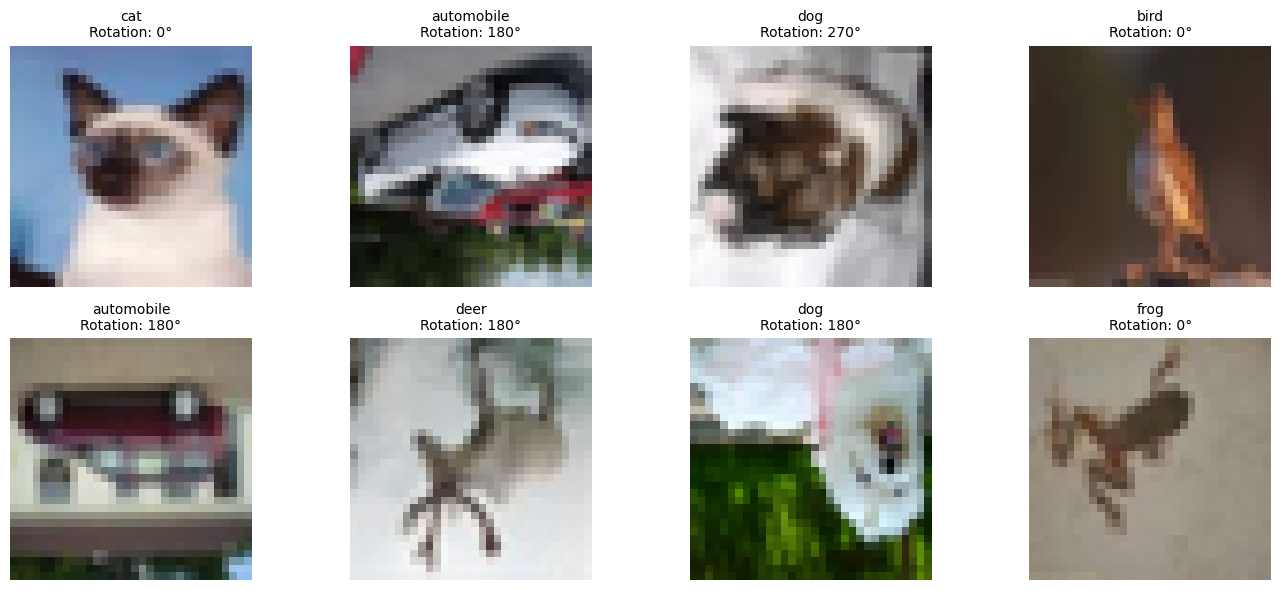

In [8]:
# -------------------------------------------
# Visualize a Sample Batch
# -------------------------------------------
# We visualize a few samples to ensure
# the data loading and transformations are working as expected.

def imshow(img):
    """Helper function to display an image."""
    npimg = img.numpy() # Covert the image to Numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from [C, H, W] to [H, W, C]
    plt.axis('off')

print("\nVisualize a sample batch...")

# Get one batch of training images.
dataiter = iter(train_loader)
images, labels_t1, labels_t2 = next(dataiter)

# CIFAR-10 class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
# Task 2 labesl
rotation_labels = ['0°', '90°', '180°', '270°']


def imshow_denorm(img, mean, std):
    """Helper function to de-normalize and display an image."""

    # Ensure std and mean are in [C, 1, 1] shape for broadcasting
    std = torch.tensor(std).view(3, 1, 1)
    mean = torch.tensor(mean).view(3, 1, 1)

    # De-normalize: img * std + mean
    img = img * std + mean

    # Clip to [0, 1] to handle potential floating point inaccuracies
    # and ensure it's a valid range for imshow
    img = torch.clamp(img, 0, 1)

    # Convert to NumPy and transpose
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # from [C, H, W] to [H, W, C]
    plt.axis('off')


# Plot each image in a 2x4 grid with corresponding labels
# We will show just 8 samples
plt.figure(figsize=(14, 6))
for idx in range(len(images[:8])):
    plt.subplot(2, 4, idx+1)
    imshow_denorm(images[idx], mean, std)
    title = f"{class_names[labels_t1[idx]]}\nRotation: {rotation_labels[labels_t2[idx]]}"
    plt.title(title, fontsize=10)
plt.tight_layout()
plt.show()

## 3. Architectures
To define the architectures we will use, which are based on **AlexNet**, we need:
1.  A base `AlexNet` class.
2.  A `HardMTL` class implementing hard parameter sharing.
3.  A `CrossStitchUnit` and `CrossStitchNetwork` for soft sharing.
4.  A `SingleTask` wrapper for STL.


### 3.1. Base AlexNet

In [ ]:
class AlexNet(nn.Module):
    """
    Implementation of the AlexNet architecture, adapted for CIFAR-10.
    """
    def __init__(self, num_outputs=10):
        """
        Initializes the AlexNet model.

        Args:
            num_outputs (int): The number of output neurons in the final layer.
                               This will depend on the task (10 for T1, 4 for T2).
        """
        super(AlexNet, self).__init__() # Always call the parent constructor.

        # --- Feature Extractor (Convolutional Layers) ---
        # This part extracts features from the input image.
        self.features = nn.Sequential(
            # Layer 1: Conv -> ReLU -> MaxPool
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1), # CIFAR-10 is small (32x32), so we adapt AlexNet.
            nn.ReLU(inplace=True), # ReLU (Rectified Linear Unit) is a common activation function. 'inplace=True' saves memory.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max-pooling reduces spatial dimensions, providing some translation invariance.

            # Layer 2: Conv -> ReLU -> MaxPool
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Layer 3: Conv -> ReLU
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 4: Conv -> ReLU
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # Layer 5: Conv -> ReLU -> MaxPool
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # --- Classifier (Fully-Connected Layers) ---
        # This part takes the extracted features and performs classification.
        self.classifier = nn.Sequential(
            nn.Dropout(0.5), # Dropout is a regularization technique to prevent overfitting. It randomly sets some activations to 0.
            nn.Linear(256 * 4 * 4, 1024), # Linear (fully-connected) layer. Input size = channels * height * width.
            nn.ReLU(inplace=True),

            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, num_outputs), # The final output layer, size depends on the task.
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x (torch.Tensor): The input tensor (batch of images).

        Returns:
            torch.Tensor: The output tensor (logits for each class).
        """
        # Pass through feature extractor.
        x = self.features(x)
        # Flatten the output for the classifier.
        # torch.flatten(x, 1) flattens all dimensions except the batch dimension (dim 0).
        x = torch.flatten(x, 1)
        # Pass through classifier.
        logits = self.classifier(x)
        return logits

### 3.2. Hard Parameter Sharing MTL (`HardMTL`)

This model has one `features` part (shared) and two `classifier` parts (task-specific).

In [10]:
class HardMTL(nn.Module):
    """
    Implements a Hard Parameter Sharing Multi-Task Learning model
    using AlexNet as the base.
    """
    def __init__(self):
        super(HardMTL, self).__init__()
        # --- Shared Feature Extractor ---
        # We take the feature extractor directly from the base AlexNet.
        # These weights will be updated by gradients from BOTH tasks.
        self.features = AlexNet().features

        # --- Task-Specific Classifiers ---
        # We create two separate classifiers, one for each task.
        # We reuse the structure of the AlexNet classifier but adjust the
        # final output layer size for each task.
        self.classifier_t1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T1), # Output for Task 1
        )
        self.classifier_t2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, NUM_CLASSES_T2), # Output for Task 2
        )

    def forward(self, x):
        """
        Defines the forward pass for the Hard MTL model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            tuple: (output_t1, output_t2)
                   - output_t1: Logits for Task 1.
                   - output_t2: Logits for Task 2.
        """
        # Pass through the shared layers.
        x = self.features(x)

        x = torch.flatten(x, 1)

        # Pass through the task-specific heads.
        logits_t1 = self.classifier_t1(x)
        logits_t2 = self.classifier_t2(x)

        return logits_t1, logits_t2

### 3.3. Soft Parameter Sharing (Cross-Stitch Network)
Cross-Stitch Networks are a deep learning architectures for Multi-Task Learning (MTL). Their main idea is to let separate networks, each working on a different task, choose how to share and mix information at different layers. This happens using "cross-stitch" units that learn to linearly combine features from each task's pathway. By figuring out how much information to share or keep separate for each task, these networks aim to improve how well they do on all related tasks at once. They try to use shared features when helpful but also allow each task to learn its own features.

Here we need to modify the **AlexNet** implementation in order to better place cross-stitch units.

In [11]:
class AlexNet_mod(nn.Module):
    def __init__(self, num_outputs=10):
        super(AlexNet_mod, self).__init__()

        # Convolutional Block 1 (Conv1 -> ReLU -> MaxPool1)
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 64, 16, 16
        )
        # Convolutional Block 2 (Conv2 -> ReLU -> MaxPool2)
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 192, 8, 8
        )
        # Convolutional Block 3 (Conv3 -> ReLU -> Conv4 -> ReLU -> Conv5 -> ReLU -> MaxPool3)
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # Output: B, 256, 4, 4
        )

        # Classifier Fully-Connected Block 1
        self.fc_block1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Classifier Fully-Connected Block 2
        self.fc_block2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True) # Output: B, 1024
        )
        # Final Output Layer
        self.output_layer = nn.Linear(1024, num_outputs)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = torch.flatten(x, 1)
        x = self.fc_block1(x)
        x = self.fc_block2(x)
        logits = self.output_layer(x)
        return logits

#### 3.3.1. Cross-Stitch Unit

Cross-Stitch unit allows adaptive information sharing between parallel network branches, here referred to as A and B. At a given layer $l$ where a cross-stitch unit is implemented, let $x_A^{(l)}$ and $x_B^{(l)}$ denote the input activation tensors (feature maps or vectors) from the respective preceding layers of networks A and B.

The core function of the cross-stitch unit at layer $l$ is to transform these input activations into new combined activations, $\tilde{x}_A^{(l)}$ and $\tilde{x}_B^{(l)}$. These transformed activations subsequently serve as inputs to the next layer within their respective network pathways. This transformation is achieved via a learned linear combination, governed by a $2 \times 2$ matrix of scalar parameters:

$$
\begin{bmatrix} \tilde{x}_A^{(l)} \\ \tilde{x}_B^{(l)} \end{bmatrix} =
\begin{bmatrix} \alpha_{AA}^{(l)} & \alpha_{AB}^{(l)} \\ \alpha_{BA}^{(l)} & \alpha_{BB}^{(l)} \end{bmatrix}
\begin{bmatrix} x_A^{(l)} \\ x_B^{(l)} \end{bmatrix}
$$

In this formulation:
-   The diagonal parameters, $\alpha_{AA}^{(l)}$ and $\alpha_{BB}^{(l)}$ (referred to as $\alpha_S$ or same-task weights), modulate the extent to which each task's original activation is propagated within its own network stream.
-   The off-diagonal parameters, $\alpha_{AB}^{(l)}$ and $\alpha_{BA}^{(l)}$ (referred to as $\alpha_D$ or different-task weights), control the degree of influence or "cross-talk" from one task's activations to the other (i.e., how much task B's features affect task A, and vice-versa).

These $\alpha$ parameters are learned independently for each cross-stitch unit deployed at different layers $l$, enabling the network to develop a layer-specific, adaptive sharing strategy tailored to the inter-dependencies of the tasks at various levels of feature abstraction.

In [ ]:
class CrossStitchUnit(nn.Module):
    """
    Implements a Cross-Stitch unit.
    This unit learns a 2x2 matrix (alpha) to linearly combine the
    feature maps from two task-specific networks.
    """
    def __init__(self):
        """
        Initializes the Cross-Stitch unit.
        """
        super(CrossStitchUnit, self).__init__()
        # --- Learnable Alpha Matrix ---
        # nn.Parameter tells PyTorch that this tensor should be considered
        # a model parameter, meaning it should be tracked for gradients
        # and updated during training by the optimizer.
        # We use a 2x2 matrix because we have two tasks.
        # We initialize all values to 0.5
        self.alpha = nn.Parameter(torch.ones(2, 2) * 0.5)

    def forward(self, x1, x2):
        """
        Performs the cross-stitch operation.

        Args:
            x1 (torch.Tensor): Feature map from Task 1's network.
            x2 (torch.Tensor): Feature map from Task 2's network.

        Returns:
            tuple: (out1, out2)
                   - out1: Combined feature map for Task 1.
                   - out2: Combined feature map for Task 2.
        """
        # Apply softmax to the alpha matrix to ensure the weights sum to 1.
        alpha = torch.softmax(self.alpha, dim=1) # Softmax along the rows (dim=1)

        # Perform the cross-stitch operation
        out1 = alpha[0, 0] * x1 + alpha[0, 1] * x2
        out2 = alpha[1, 0] * x1 + alpha[1, 1] * x2
        return out1, out2


#### 3.3.2. CrossStitchNetwork
The `CrossStitchNetwork` class implements the architecture of a Cross-Stitch Network according to the following schema:

<div align="center">
  <img src="images/AlexNet-Cross-Stitch.PNG" alt="Cross-Stitch Network Architecture" width="600">
</div>

---
Misra, I., Shrivastava, A., Gupta, A., & Hebert, M. (2016). *Cross-stitch Networks for Multi-task Learning*. arXiv:1604.03539. [https://arxiv.org/abs/1604.03539](https://arxiv.org/abs/1604.03539)

In [ ]:
class CrossStitchNetwork(nn.Module):
    """
    Implements a Cross-Stitch Network using two modified AlexNet backbones,
    with cross-stitch layers applied after every pooling and FC layer.
    """
    def __init__(self):
        super(CrossStitchNetwork, self).__init__()

        self.task1_net = AlexNet_mod(num_outputs=NUM_CLASSES_T1)
        self.task2_net = AlexNet_mod(num_outputs=NUM_CLASSES_T2)

        # --- Cross-Stitch Layers ---
        self.cs_pool1 = CrossStitchUnit()
        self.cs_pool2 = CrossStitchUnit()
        self.cs_pool3 = CrossStitchUnit()

        self.cs_fc1 = CrossStitchUnit()
        self.cs_fc2 = CrossStitchUnit()


    def forward(self, x):
        """
        Defines the forward pass for the Cross-Stitch Network.
        Args:
            x (torch.Tensor): The input tensor.
        Returns:
            tuple: (out1, out2) - Logits for Task 1 and Task 2.
        """
        # --- Initial Input ---
        # Both networks process the same input initially
        x_t1 = x
        x_t2 = x

        # --- Conv Block 1 (includes Pool1) ---
        x_t1_p1 = self.task1_net.conv_block1(x_t1)
        x_t2_p1 = self.task2_net.conv_block1(x_t2)

        x_t1_p1_cs, x_t2_p1_cs = self.cs_pool1(x_t1_p1, x_t2_p1)

        # --- Conv Block 2 (includes Pool2) ---
        x_t1_p2 = self.task1_net.conv_block2(x_t1_p1_cs)
        x_t2_p2 = self.task2_net.conv_block2(x_t2_p1_cs)

        x_t1_p2_cs, x_t2_p2_cs = self.cs_pool2(x_t1_p2, x_t2_p2)

        # --- Conv Block 3 (includes Pool3) ---
        x_t1_p3 = self.task1_net.conv_block3(x_t1_p2_cs)
        x_t2_p3 = self.task2_net.conv_block3(x_t2_p2_cs)

        x_t1_p3_cs, x_t2_p3_cs = self.cs_pool3(x_t1_p3, x_t2_p3)

        # Flatten for Classifier
        x_t1_flat = torch.flatten(x_t1_p3_cs, 1)
        x_t2_flat = torch.flatten(x_t2_p3_cs, 1)

        # --- FC Block 1 ---
        x_t1_fc1 = self.task1_net.fc_block1(x_t1_flat)
        x_t2_fc1 = self.task2_net.fc_block1(x_t2_flat)

        x_t1_fc1_cs, x_t2_fc1_cs = self.cs_fc1(x_t1_fc1, x_t2_fc1)

        # --- FC Block 2 ---
        x_t1_fc2 = self.task1_net.fc_block2(x_t1_fc1_cs)
        x_t2_fc2 = self.task2_net.fc_block2(x_t2_fc1_cs)

        x_t1_fc2_cs, x_t2_fc2_cs = self.cs_fc2(x_t1_fc2, x_t2_fc2)

        # --- Final Output Layers ---
        logits_t1 = self.task1_net.output_layer(x_t1_fc2_cs)
        logits_t2 = self.task2_net.output_layer(x_t2_fc2_cs)

        return logits_t1, logits_t2


### 3.4. Single-Task Learning (`SingleTask`)

This is simply a wrapper around the base `AlexNet` to fit into our training framework easily.

In [14]:
class SingleTask(nn.Module):
    """
    A simple wrapper for AlexNet to represent a Single-Task Learning model.
    """
    def __init__(self, num_outputs):
        super(SingleTask, self).__init__()
        self.model = AlexNet(num_outputs=num_outputs)

    def forward(self, x):
        return self.model(x)

## 4. Training and Evaluation Utilities

We define functions to handle the training and evaluation loops. This keeps our main code cleaner and avoids repetition. We need separate functions for MTL (handling two outputs and losses) and STL (handling one).

**Key PyTorch Steps in Training:**

1.  `model.train()`: Sets the model to training mode (enables dropout, batch norm updates, etc.).
2.  `optimizer.zero_grad()`: Clears old gradients before calculating new ones.
3.  `outputs = model(inputs)`: Performs the forward pass.
4.  `loss = criterion(outputs, labels)`: Calculates the loss.
5.  `loss.backward()`: Computes gradients of the loss w.r.t. model parameters.
6.  `optimizer.step()`: Updates model parameters using the computed gradients and the chosen optimization algorithm.

**Key PyTorch Steps in Evaluation:**

1.  `model.eval()`: Sets the model to evaluation mode (disables dropout, etc.).
2.  `with torch.no_grad()`: Disables gradient calculation, saving memory and computation, as we don't need gradients during evaluation.


In [ ]:
# Define the loss function. CrossEntropyLoss is standard for classification.
# It combines LogSoftmax and NLLLoss in one class.
criterion = nn.CrossEntropyLoss()

def generic_train_epoch_mtl(model, loader, optimizer, criterion, device, epoch_num):
    """
    Trains an MTL model for one epoch.
    """
    model.train() # Set model to training mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    # Use tqdm for a progress bar.
    progress_bar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels_t1, labels_t2 in progress_bar:
        # Move data to the selected device (GPU/CPU)
        inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

        # --- Forward Pass ---
        optimizer.zero_grad() # Zero the parameter gradients
        outputs_t1, outputs_t2 = model(inputs) # Get model outputs

        # --- Loss Calculation ---
        loss_t1 = criterion(outputs_t1, labels_t1)
        loss_t2 = criterion(outputs_t2, labels_t2)
        # Simple MTL loss: Sum of individual task losses.
        # More advanced methods might weigh these differently.
        total_loss = loss_t1 + loss_t2

        # --- Backward Pass & Optimization ---
        total_loss.backward() # Compute gradients
        optimizer.step() # Update weights

        # --- Statistics ---
        _, preds_t1 = torch.max(outputs_t1, 1) # Get predicted class index (highest logit)
        _, preds_t2 = torch.max(outputs_t2, 1)

        running_total_loss += total_loss.item() * images.size(0)
        running_loss_t1 += loss_t1.item() * inputs.size(0)
        running_loss_t2 += loss_t2.item() * inputs.size(0)

        running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
        running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

        total_samples += inputs.size(0)

        # Update progress bar
        progress_bar.set_postfix(
            loss=f"{total_loss.item():.4f}",
            loss_t1=f"{loss_t1.item():.4f}", acc_t1=f"{(torch.sum(preds_t1 == labels_t1.data)/inputs.size(0))*100:.2f}%",
            loss_t2=f"{loss_t2.item():.4f}", acc_t2=f"{(torch.sum(preds_t2 == labels_t2.data)/inputs.size(0))*100:.2f}%"
        )

    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


def generic_evaluate_epoch_mtl(model, loader, criterion, device, epoch_num, phase="Validation"):
    """
    Evaluates an MTL model for one epoch.
    """
    model.eval() # Set model to evaluation mode
    running_total_loss = 0.0
    running_loss_t1 = 0.0
    running_loss_t2 = 0.0
    running_corrects_t1 = 0
    running_corrects_t2 = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"{phase}", leave=False)

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels_t1, labels_t2 in progress_bar:
            inputs, labels_t1, labels_t2 = inputs.to(device), labels_t1.to(device), labels_t2.to(device)

            outputs_t1, outputs_t2 = model(inputs)
            loss_t1 = criterion(outputs_t1, labels_t1)
            loss_t2 = criterion(outputs_t2, labels_t2)

            total_loss = loss_t1 + loss_t2

            _, preds_t1 = torch.max(outputs_t1, 1)
            _, preds_t2 = torch.max(outputs_t2, 1)

            running_total_loss += total_loss.item() * images.size(0)
            running_loss_t1 += loss_t1.item() * inputs.size(0)
            running_loss_t2 += loss_t2.item() * inputs.size(0)

            running_corrects_t1 += torch.sum(preds_t1 == labels_t1.data)
            running_corrects_t2 += torch.sum(preds_t2 == labels_t2.data)

            total_samples += inputs.size(0)

            progress_bar.set_postfix(
                loss=f"{total_loss.item():.4f}",
                loss_t1=f"{loss_t1.item():.4f}", acc_t1=f"{(torch.sum(preds_t1 == labels_t1.data)/inputs.size(0))*100:.2f}%",
                loss_t2=f"{loss_t2.item():.4f}", acc_t2=f"{(torch.sum(preds_t2 == labels_t2.data)/inputs.size(0))*100:.2f}%"
            )
    epoch_total_loss = running_total_loss / total_samples
    epoch_loss_t1 = running_loss_t1 / total_samples
    epoch_acc_t1 = running_corrects_t1.double() / total_samples
    epoch_loss_t2 = running_loss_t2 / total_samples
    epoch_acc_t2 = running_corrects_t2.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}:' if epoch_num else ''}\n- Loss: {epoch_total_loss:.4f}\n- T1: Loss: {epoch_loss_t1:.4f} - Acc: {epoch_acc_t1*100:.2f}%\n"
          f"- T2: Loss: {epoch_loss_t2:.4f} - Acc: {epoch_acc_t2*100:.2f}%")

    return epoch_total_loss, epoch_loss_t1, epoch_acc_t1.item(), epoch_loss_t2, epoch_acc_t2.item()


# --- Functions for STL ---
# These are similar but simpler as they only handle one task.
def generic_train_epoch_stl(model, loader, optimizer, criterion, device, task_id, epoch_num):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"Training on {task_id}", leave=False)

    for inputs, labels_t1, labels_t2 in progress_bar:
        labels = labels_t1 if task_id == "task1" else labels_t2
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0))*100:.4f}%")

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"Training, Epoch {epoch_num}:\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()


def generic_evaluate_epoch_stl(model, loader, criterion, device, task_id, epoch_num, phase="Validation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(loader, desc=f"{phase} on {task_id}", leave=False)

    with torch.no_grad():
        for inputs, labels_t1, labels_t2 in progress_bar:
            labels = labels_t1 if task_id == "task1" else labels_t2
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{(torch.sum(preds == labels.data)/inputs.size(0))*100:.2f}%")

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples

    print(f"{phase}{f', Epoch {epoch_num}: ' if epoch_num else ''}\n- Loss: {epoch_loss:.4f} - Acc: {epoch_acc*100:.2f}%")
    return epoch_loss, epoch_acc.item()

In [16]:
# --- Generic Training Loop ---
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, model_type, save_path, task_id=None, alpha_history_list=None):
    """
    A generic function to train either MTL or STL models.
    """
    best_validation_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    if model_type == 'mtl':
        history = {'train_loss': [], 'val_loss': [], 'train_loss_t1': [], 'train_acc_t1': [], 'val_loss_t1': [], 'val_acc_t1': [],
                   'train_loss_t2': [], 'train_acc_t2': [], 'val_loss_t2': [], 'val_acc_t2': []}

    for epoch in range(1, num_epochs + 1):
        if model_type == 'mtl':
            train_loss, train_loss_t1, train_acc_t1, train_loss_t2, train_acc_t2 = generic_train_epoch_mtl(
                model, train_loader, optimizer, criterion, device, epoch
            )
            val_loss, val_loss_t1, val_acc_t1, val_loss_t2, val_acc_t2 = generic_evaluate_epoch_mtl(
                model, val_loader, criterion, device, epoch
            )

            history['train_loss_t1'].append(train_loss_t1)
            history['train_acc_t1'].append(train_acc_t1)
            history['val_loss_t1'].append(val_loss_t1)
            history['val_acc_t1'].append(val_acc_t1)
            history['train_loss_t2'].append(train_loss_t2)
            history['train_acc_t2'].append(train_acc_t2)
            history['val_loss_t2'].append(val_loss_t2)
            history['val_acc_t2'].append(val_acc_t2)

            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)

            current_validation_loss = val_loss

        else: # STL
            train_loss, train_acc = generic_train_epoch_stl(
                model, train_loader, optimizer, criterion, device, task_id, epoch
            )
            val_loss, val_acc = generic_evaluate_epoch_stl(
                model, val_loader, criterion, device, task_id, epoch
            )

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            current_validation_loss = val_loss

        # Save alpha values if training Cross-Stitch
        if alpha_history_list is not None and isinstance(model, CrossStitchNetwork):
            alpha_history_list[0].append(model.cs_pool1.alpha.data.cpu().numpy().copy())
            alpha_history_list[1].append(model.cs_pool2.alpha.data.cpu().numpy().copy())
            alpha_history_list[2].append(model.cs_pool3.alpha.data.cpu().numpy().copy())

            alpha_history_list[3].append(model.cs_fc1.alpha.data.cpu().numpy().copy())
            alpha_history_list[4].append(model.cs_fc2.alpha.data.cpu().numpy().copy())

        # Save the best model based on validation loss
        if current_validation_loss < best_validation_loss:
            best_validation_loss = current_validation_loss
            torch.save(model.state_dict(), save_path)

    return history

## 4. Training The Models

Now we put everything together and train each of our models: Hard MTL, Cross-Stitch MTL, and the two STL models.

### 4.1. Hard Parameter Sharing MTL Training

We instantiate the `HardMTL` model, move it to the configured device, set up the Adam optimizer, and start the training loop.

In [17]:
print("--- Training Hard Parameter Sharing MTL ---")
model_hard_mtl = HardMTL().to(device)
optimizer_hard_mtl = optim.Adam(model_hard_mtl.parameters(), lr=LEARNING_RATE)

history_hard_mtl = train_model(
    model_hard_mtl, train_loader, test_loader, optimizer_hard_mtl, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_hard_mtl_model.pt'
)
print("--- Hard MTL Training Finished ---\n")

--- Training Hard Parameter Sharing MTL ---


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 2.4735
- T1: Loss: 1.5363 - Acc: 43.33%
- T2: Loss: 0.9364 - Acc: 60.00%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1:
- Loss: 2.0268
- T1: Loss: 1.2304 - Acc: 55.50%
- T2: Loss: 0.7931 - Acc: 67.29%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 1.8540
- T1: Loss: 1.1257 - Acc: 59.43%
- T2: Loss: 0.7277 - Acc: 70.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2:
- Loss: 1.6720
- T1: Loss: 1.0109 - Acc: 63.45%
- T2: Loss: 0.6581 - Acc: 73.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 1.6042
- T1: Loss: 0.9722 - Acc: 65.42%
- T2: Loss: 0.6315 - Acc: 74.87%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3:
- Loss: 1.5719
- T1: Loss: 0.9472 - Acc: 66.33%
- T2: Loss: 0.6222 - Acc: 75.13%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 1.4622
- T1: Loss: 0.8851 - Acc: 68.61%
- T2: Loss: 0.5767 - Acc: 77.30%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4:
- Loss: 1.4002
- T1: Loss: 0.8373 - Acc: 70.48%
- T2: Loss: 0.5608 - Acc: 78.12%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 1.3633
- T1: Loss: 0.8242 - Acc: 70.93%
- T2: Loss: 0.5386 - Acc: 78.95%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5:
- Loss: 1.3837
- T1: Loss: 0.8439 - Acc: 70.48%
- T2: Loss: 0.5375 - Acc: 79.23%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 1.2871
- T1: Loss: 0.7788 - Acc: 72.56%
- T2: Loss: 0.5079 - Acc: 80.23%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6:
- Loss: 1.3206
- T1: Loss: 0.7914 - Acc: 72.47%
- T2: Loss: 0.5270 - Acc: 79.53%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 1.2228
- T1: Loss: 0.7389 - Acc: 74.04%
- T2: Loss: 0.4835 - Acc: 81.11%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7:
- Loss: 1.2644
- T1: Loss: 0.7614 - Acc: 73.69%
- T2: Loss: 0.5003 - Acc: 80.51%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 1.1709
- T1: Loss: 0.7090 - Acc: 75.17%
- T2: Loss: 0.4616 - Acc: 82.14%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8:
- Loss: 1.2665
- T1: Loss: 0.7544 - Acc: 73.62%
- T2: Loss: 0.5096 - Acc: 80.36%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 1.1270
- T1: Loss: 0.6824 - Acc: 76.04%
- T2: Loss: 0.4442 - Acc: 82.89%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9:
- Loss: 1.2557
- T1: Loss: 0.7566 - Acc: 73.84%
- T2: Loss: 0.4966 - Acc: 80.47%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 1.0850
- T1: Loss: 0.6609 - Acc: 76.74%
- T2: Loss: 0.4238 - Acc: 83.78%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10:
- Loss: 1.2240
- T1: Loss: 0.7441 - Acc: 74.26%
- T2: Loss: 0.4779 - Acc: 81.59%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 1.0477
- T1: Loss: 0.6373 - Acc: 77.68%
- T2: Loss: 0.4101 - Acc: 84.31%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11:
- Loss: 1.2064
- T1: Loss: 0.7380 - Acc: 74.65%
- T2: Loss: 0.4659 - Acc: 82.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 1.0147
- T1: Loss: 0.6189 - Acc: 78.34%
- T2: Loss: 0.3955 - Acc: 84.79%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12:
- Loss: 1.1934
- T1: Loss: 0.7267 - Acc: 75.30%
- T2: Loss: 0.4647 - Acc: 82.18%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.9856
- T1: Loss: 0.6023 - Acc: 78.95%
- T2: Loss: 0.3829 - Acc: 85.42%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13:
- Loss: 1.1738
- T1: Loss: 0.7094 - Acc: 75.89%
- T2: Loss: 0.4622 - Acc: 82.31%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.9499
- T1: Loss: 0.5814 - Acc: 79.70%
- T2: Loss: 0.3682 - Acc: 86.00%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14:
- Loss: 1.1822
- T1: Loss: 0.7130 - Acc: 75.77%
- T2: Loss: 0.4673 - Acc: 81.92%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.9210
- T1: Loss: 0.5632 - Acc: 80.30%
- T2: Loss: 0.3574 - Acc: 86.46%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15:
- Loss: 1.1878
- T1: Loss: 0.7269 - Acc: 75.36%
- T2: Loss: 0.4586 - Acc: 82.41%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.8935
- T1: Loss: 0.5478 - Acc: 80.87%
- T2: Loss: 0.3455 - Acc: 86.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16:
- Loss: 1.1680
- T1: Loss: 0.6996 - Acc: 76.25%
- T2: Loss: 0.4666 - Acc: 82.47%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.8668
- T1: Loss: 0.5336 - Acc: 81.41%
- T2: Loss: 0.3329 - Acc: 87.35%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17:
- Loss: 1.1535
- T1: Loss: 0.6954 - Acc: 76.56%
- T2: Loss: 0.4557 - Acc: 82.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.8461
- T1: Loss: 0.5197 - Acc: 81.94%
- T2: Loss: 0.3261 - Acc: 87.71%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18:
- Loss: 1.1452
- T1: Loss: 0.6915 - Acc: 76.66%
- T2: Loss: 0.4514 - Acc: 82.94%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.8220
- T1: Loss: 0.5057 - Acc: 82.50%
- T2: Loss: 0.3159 - Acc: 88.07%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19:
- Loss: 1.1744
- T1: Loss: 0.7041 - Acc: 76.53%
- T2: Loss: 0.4683 - Acc: 83.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.8023
- T1: Loss: 0.4923 - Acc: 82.98%
- T2: Loss: 0.3097 - Acc: 88.42%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20:
- Loss: 1.1520
- T1: Loss: 0.7099 - Acc: 76.37%
- T2: Loss: 0.4396 - Acc: 83.37%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.7824
- T1: Loss: 0.4818 - Acc: 83.31%
- T2: Loss: 0.3003 - Acc: 88.75%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21:
- Loss: 1.1512
- T1: Loss: 0.6965 - Acc: 76.79%
- T2: Loss: 0.4523 - Acc: 83.04%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.7718
- T1: Loss: 0.4748 - Acc: 83.62%
- T2: Loss: 0.2967 - Acc: 88.98%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22:
- Loss: 1.1815
- T1: Loss: 0.7224 - Acc: 76.75%
- T2: Loss: 0.4569 - Acc: 83.14%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.7566
- T1: Loss: 0.4663 - Acc: 83.94%
- T2: Loss: 0.2901 - Acc: 89.16%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23:
- Loss: 1.1602
- T1: Loss: 0.7112 - Acc: 76.54%
- T2: Loss: 0.4469 - Acc: 83.12%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.7347
- T1: Loss: 0.4552 - Acc: 84.33%
- T2: Loss: 0.2794 - Acc: 89.60%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24:
- Loss: 1.1764
- T1: Loss: 0.7114 - Acc: 77.26%
- T2: Loss: 0.4627 - Acc: 83.48%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.7224
- T1: Loss: 0.4475 - Acc: 84.63%
- T2: Loss: 0.2747 - Acc: 89.80%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25:
- Loss: 1.1782
- T1: Loss: 0.7195 - Acc: 76.74%
- T2: Loss: 0.4566 - Acc: 83.71%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.7151
- T1: Loss: 0.4408 - Acc: 84.90%
- T2: Loss: 0.2741 - Acc: 89.86%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26:
- Loss: 1.1715
- T1: Loss: 0.7285 - Acc: 76.72%
- T2: Loss: 0.4408 - Acc: 83.68%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.6876
- T1: Loss: 0.4262 - Acc: 85.41%
- T2: Loss: 0.2610 - Acc: 90.26%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27:
- Loss: 1.1944
- T1: Loss: 0.7440 - Acc: 77.17%
- T2: Loss: 0.4480 - Acc: 83.60%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.6916
- T1: Loss: 0.4271 - Acc: 85.47%
- T2: Loss: 0.2643 - Acc: 90.24%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28:
- Loss: 1.1678
- T1: Loss: 0.7153 - Acc: 77.52%
- T2: Loss: 0.4506 - Acc: 83.61%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.6667
- T1: Loss: 0.4137 - Acc: 85.91%
- T2: Loss: 0.2528 - Acc: 90.71%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29:
- Loss: 1.2283
- T1: Loss: 0.7639 - Acc: 76.39%
- T2: Loss: 0.4621 - Acc: 82.83%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.6648
- T1: Loss: 0.4118 - Acc: 86.07%
- T2: Loss: 0.2528 - Acc: 90.68%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30:
- Loss: 1.2128
- T1: Loss: 0.7483 - Acc: 76.61%
- T2: Loss: 0.4620 - Acc: 83.30%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.6596
- T1: Loss: 0.4078 - Acc: 86.19%
- T2: Loss: 0.2515 - Acc: 90.75%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31:
- Loss: 1.2031
- T1: Loss: 0.7505 - Acc: 76.57%
- T2: Loss: 0.4506 - Acc: 83.47%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.6419
- T1: Loss: 0.4005 - Acc: 86.44%
- T2: Loss: 0.2411 - Acc: 91.13%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32:
- Loss: 1.2150
- T1: Loss: 0.7459 - Acc: 76.76%
- T2: Loss: 0.4670 - Acc: 82.88%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.6455
- T1: Loss: 0.3997 - Acc: 86.52%
- T2: Loss: 0.2456 - Acc: 91.08%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33:
- Loss: 1.1998
- T1: Loss: 0.7400 - Acc: 77.03%
- T2: Loss: 0.4577 - Acc: 83.81%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.6403
- T1: Loss: 0.3955 - Acc: 86.76%
- T2: Loss: 0.2446 - Acc: 91.15%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34:
- Loss: 1.2726
- T1: Loss: 0.7998 - Acc: 75.86%
- T2: Loss: 0.4703 - Acc: 83.42%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.6255
- T1: Loss: 0.3894 - Acc: 87.00%
- T2: Loss: 0.2359 - Acc: 91.44%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35:
- Loss: 1.1916
- T1: Loss: 0.7407 - Acc: 77.45%
- T2: Loss: 0.4489 - Acc: 83.61%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.6453
- T1: Loss: 0.4028 - Acc: 86.61%
- T2: Loss: 0.2423 - Acc: 91.28%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36:
- Loss: 1.2541
- T1: Loss: 0.7675 - Acc: 77.15%
- T2: Loss: 0.4844 - Acc: 83.53%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.6157
- T1: Loss: 0.3826 - Acc: 87.27%
- T2: Loss: 0.2329 - Acc: 91.56%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37:
- Loss: 1.2096
- T1: Loss: 0.7618 - Acc: 77.65%
- T2: Loss: 0.4456 - Acc: 84.01%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.6328
- T1: Loss: 0.3926 - Acc: 86.97%
- T2: Loss: 0.2400 - Acc: 91.35%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38:
- Loss: 1.2311
- T1: Loss: 0.7641 - Acc: 77.44%
- T2: Loss: 0.4645 - Acc: 84.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.6079
- T1: Loss: 0.3786 - Acc: 87.46%
- T2: Loss: 0.2291 - Acc: 91.68%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39:
- Loss: 1.2382
- T1: Loss: 0.7668 - Acc: 77.09%
- T2: Loss: 0.4692 - Acc: 83.60%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.6056
- T1: Loss: 0.3755 - Acc: 87.52%
- T2: Loss: 0.2299 - Acc: 91.76%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40:
- Loss: 1.2153
- T1: Loss: 0.7563 - Acc: 77.11%
- T2: Loss: 0.4566 - Acc: 83.45%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.6084
- T1: Loss: 0.3799 - Acc: 87.53%
- T2: Loss: 0.2282 - Acc: 91.76%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41:
- Loss: 1.2733
- T1: Loss: 0.8098 - Acc: 76.21%
- T2: Loss: 0.4613 - Acc: 83.43%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.5997
- T1: Loss: 0.3746 - Acc: 87.69%
- T2: Loss: 0.2249 - Acc: 91.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42:
- Loss: 1.2389
- T1: Loss: 0.7542 - Acc: 77.40%
- T2: Loss: 0.4827 - Acc: 83.93%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.6156
- T1: Loss: 0.3809 - Acc: 87.55%
- T2: Loss: 0.2345 - Acc: 91.75%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43:
- Loss: 1.2361
- T1: Loss: 0.7671 - Acc: 77.10%
- T2: Loss: 0.4666 - Acc: 83.43%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.5945
- T1: Loss: 0.3707 - Acc: 87.88%
- T2: Loss: 0.2237 - Acc: 91.94%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44:
- Loss: 1.2443
- T1: Loss: 0.7802 - Acc: 77.70%
- T2: Loss: 0.4618 - Acc: 84.26%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.5997
- T1: Loss: 0.3754 - Acc: 87.81%
- T2: Loss: 0.2240 - Acc: 92.04%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45:
- Loss: 1.2457
- T1: Loss: 0.7687 - Acc: 77.76%
- T2: Loss: 0.4745 - Acc: 83.96%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.6116
- T1: Loss: 0.3813 - Acc: 87.59%
- T2: Loss: 0.2301 - Acc: 91.82%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46:
- Loss: 1.2659
- T1: Loss: 0.7764 - Acc: 77.58%
- T2: Loss: 0.4874 - Acc: 83.72%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.6230
- T1: Loss: 0.3877 - Acc: 87.34%
- T2: Loss: 0.2352 - Acc: 91.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47:
- Loss: 1.2934
- T1: Loss: 0.8152 - Acc: 76.66%
- T2: Loss: 0.4758 - Acc: 83.03%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.6020
- T1: Loss: 0.3747 - Acc: 87.86%
- T2: Loss: 0.2270 - Acc: 91.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48:
- Loss: 1.2233
- T1: Loss: 0.7685 - Acc: 78.04%
- T2: Loss: 0.4523 - Acc: 84.01%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.5966
- T1: Loss: 0.3744 - Acc: 87.87%
- T2: Loss: 0.2220 - Acc: 92.07%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49:
- Loss: 1.2714
- T1: Loss: 0.7875 - Acc: 77.03%
- T2: Loss: 0.4815 - Acc: 83.21%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.6473
- T1: Loss: 0.4076 - Acc: 86.97%
- T2: Loss: 0.2395 - Acc: 91.50%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50:
- Loss: 1.2950
- T1: Loss: 0.7944 - Acc: 77.65%
- T2: Loss: 0.4978 - Acc: 83.84%
--- Hard MTL Training Finished ---



### 4.2. Cross-Stitch Network (Soft Sharing) MTL Training

Here, we train the `CrossStitchNetwork`. We also initialize lists to store the `alpha` coefficients from each Cross-Stitch unit during training. This will allow us to visualize how the network learns to share information.

In [18]:
print("--- Training Cross-Stitch Network MTL ---")
model_cs = CrossStitchNetwork().to(device)
optimizer_cs = optim.Adam(model_cs.parameters(), lr=LEARNING_RATE)

# Lists to store alpha values (one list per CS layer)
alphas_cs1_history = []
alphas_cs2_history = []
alphas_cs3_history = []
alphas_cs4_history = []
alphas_cs5_history = []
alpha_history_list_cs = [alphas_cs1_history, alphas_cs2_history, alphas_cs3_history, alphas_cs4_history, alphas_cs5_history]

history_cs = train_model(
    model_cs, train_loader, test_loader, optimizer_cs, criterion,
    device, NUM_EPOCHS, 'mtl', 'best_alexnet_cs_model.pt',
    alpha_history_list=alpha_history_list_cs
)
print("--- Cross-Stitch Training Finished ---\n")

--- Training Cross-Stitch Network MTL ---


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 2.5967
- T1: Loss: 1.6179 - Acc: 40.17%
- T2: Loss: 0.9780 - Acc: 57.34%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1:
- Loss: 2.1229
- T1: Loss: 1.2849 - Acc: 54.42%
- T2: Loss: 0.8344 - Acc: 65.03%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 1.9645
- T1: Loss: 1.1935 - Acc: 56.95%
- T2: Loss: 0.7703 - Acc: 68.33%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2:
- Loss: 1.8103
- T1: Loss: 1.1074 - Acc: 60.63%
- T2: Loss: 0.7002 - Acc: 71.51%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 1.6708
- T1: Loss: 1.0079 - Acc: 64.01%
- T2: Loss: 0.6623 - Acc: 73.36%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3:
- Loss: 1.5264
- T1: Loss: 0.9151 - Acc: 67.70%
- T2: Loss: 0.6090 - Acc: 75.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 1.4911
- T1: Loss: 0.8968 - Acc: 68.01%
- T2: Loss: 0.5938 - Acc: 76.42%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4:
- Loss: 1.4556
- T1: Loss: 0.8698 - Acc: 69.29%
- T2: Loss: 0.5833 - Acc: 76.75%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 1.3781
- T1: Loss: 0.8260 - Acc: 70.63%
- T2: Loss: 0.5516 - Acc: 78.29%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5:
- Loss: 1.3322
- T1: Loss: 0.7968 - Acc: 72.04%
- T2: Loss: 0.5330 - Acc: 78.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 1.2868
- T1: Loss: 0.7700 - Acc: 72.60%
- T2: Loss: 0.5164 - Acc: 79.66%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6:
- Loss: 1.2840
- T1: Loss: 0.7650 - Acc: 73.38%
- T2: Loss: 0.5169 - Acc: 79.87%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 1.2102
- T1: Loss: 0.7224 - Acc: 74.33%
- T2: Loss: 0.4874 - Acc: 81.02%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7:
- Loss: 1.2540
- T1: Loss: 0.7537 - Acc: 73.69%
- T2: Loss: 0.4981 - Acc: 80.33%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 1.1450
- T1: Loss: 0.6839 - Acc: 75.69%
- T2: Loss: 0.4607 - Acc: 81.97%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8:
- Loss: 1.2194
- T1: Loss: 0.7248 - Acc: 74.68%
- T2: Loss: 0.4926 - Acc: 80.61%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 1.0912
- T1: Loss: 0.6502 - Acc: 76.96%
- T2: Loss: 0.4408 - Acc: 82.92%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9:
- Loss: 1.1689
- T1: Loss: 0.6987 - Acc: 75.88%
- T2: Loss: 0.4685 - Acc: 81.87%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 1.0443
- T1: Loss: 0.6232 - Acc: 77.87%
- T2: Loss: 0.4207 - Acc: 83.75%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10:
- Loss: 1.1671
- T1: Loss: 0.7037 - Acc: 75.43%
- T2: Loss: 0.4618 - Acc: 82.10%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 1.0014
- T1: Loss: 0.5980 - Acc: 78.68%
- T2: Loss: 0.4030 - Acc: 84.46%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11:
- Loss: 1.1499
- T1: Loss: 0.6912 - Acc: 76.45%
- T2: Loss: 0.4568 - Acc: 82.22%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 0.9627
- T1: Loss: 0.5738 - Acc: 79.65%
- T2: Loss: 0.3886 - Acc: 85.06%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12:
- Loss: 1.1163
- T1: Loss: 0.6682 - Acc: 76.92%
- T2: Loss: 0.4465 - Acc: 82.82%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.9271
- T1: Loss: 0.5522 - Acc: 80.32%
- T2: Loss: 0.3745 - Acc: 85.59%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13:
- Loss: 1.1273
- T1: Loss: 0.6794 - Acc: 76.63%
- T2: Loss: 0.4461 - Acc: 82.72%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.8934
- T1: Loss: 0.5325 - Acc: 81.00%
- T2: Loss: 0.3606 - Acc: 86.14%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14:
- Loss: 1.1134
- T1: Loss: 0.6697 - Acc: 77.24%
- T2: Loss: 0.4419 - Acc: 83.15%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.8675
- T1: Loss: 0.5157 - Acc: 81.64%
- T2: Loss: 0.3515 - Acc: 86.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15:
- Loss: 1.1074
- T1: Loss: 0.6634 - Acc: 77.44%
- T2: Loss: 0.4422 - Acc: 82.99%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.8443
- T1: Loss: 0.5025 - Acc: 82.11%
- T2: Loss: 0.3415 - Acc: 86.95%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16:
- Loss: 1.1132
- T1: Loss: 0.6711 - Acc: 77.09%
- T2: Loss: 0.4400 - Acc: 83.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.8164
- T1: Loss: 0.4849 - Acc: 82.70%
- T2: Loss: 0.3313 - Acc: 87.39%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17:
- Loss: 1.0886
- T1: Loss: 0.6582 - Acc: 78.03%
- T2: Loss: 0.4286 - Acc: 83.73%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.7899
- T1: Loss: 0.4693 - Acc: 83.28%
- T2: Loss: 0.3204 - Acc: 87.74%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18:
- Loss: 1.0954
- T1: Loss: 0.6632 - Acc: 77.55%
- T2: Loss: 0.4304 - Acc: 83.54%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.7663
- T1: Loss: 0.4556 - Acc: 83.79%
- T2: Loss: 0.3105 - Acc: 88.26%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19:
- Loss: 1.0927
- T1: Loss: 0.6603 - Acc: 77.92%
- T2: Loss: 0.4311 - Acc: 83.55%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.7516
- T1: Loss: 0.4476 - Acc: 84.00%
- T2: Loss: 0.3038 - Acc: 88.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20:
- Loss: 1.0817
- T1: Loss: 0.6537 - Acc: 78.29%
- T2: Loss: 0.4262 - Acc: 83.95%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.7284
- T1: Loss: 0.4324 - Acc: 84.60%
- T2: Loss: 0.2957 - Acc: 88.82%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21:
- Loss: 1.0764
- T1: Loss: 0.6498 - Acc: 78.23%
- T2: Loss: 0.4247 - Acc: 83.99%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.7083
- T1: Loss: 0.4212 - Acc: 85.00%
- T2: Loss: 0.2868 - Acc: 89.14%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22:
- Loss: 1.1048
- T1: Loss: 0.6676 - Acc: 77.74%
- T2: Loss: 0.4353 - Acc: 83.57%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.6995
- T1: Loss: 0.4162 - Acc: 85.24%
- T2: Loss: 0.2831 - Acc: 89.39%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23:
- Loss: 1.0932
- T1: Loss: 0.6626 - Acc: 78.20%
- T2: Loss: 0.4290 - Acc: 83.99%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.6770
- T1: Loss: 0.4015 - Acc: 85.68%
- T2: Loss: 0.2754 - Acc: 89.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24:
- Loss: 1.0902
- T1: Loss: 0.6601 - Acc: 78.33%
- T2: Loss: 0.4284 - Acc: 84.31%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.6621
- T1: Loss: 0.3922 - Acc: 86.11%
- T2: Loss: 0.2696 - Acc: 89.81%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25:
- Loss: 1.0800
- T1: Loss: 0.6523 - Acc: 78.61%
- T2: Loss: 0.4261 - Acc: 84.11%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.6512
- T1: Loss: 0.3859 - Acc: 86.27%
- T2: Loss: 0.2651 - Acc: 90.06%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26:
- Loss: 1.0829
- T1: Loss: 0.6559 - Acc: 78.40%
- T2: Loss: 0.4253 - Acc: 84.05%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.6337
- T1: Loss: 0.3745 - Acc: 86.71%
- T2: Loss: 0.2591 - Acc: 90.34%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27:
- Loss: 1.0818
- T1: Loss: 0.6587 - Acc: 78.38%
- T2: Loss: 0.4213 - Acc: 84.27%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.6228
- T1: Loss: 0.3696 - Acc: 86.92%
- T2: Loss: 0.2531 - Acc: 90.49%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28:
- Loss: 1.0892
- T1: Loss: 0.6617 - Acc: 78.55%
- T2: Loss: 0.4256 - Acc: 84.25%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.6114
- T1: Loss: 0.3619 - Acc: 87.17%
- T2: Loss: 0.2493 - Acc: 90.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29:
- Loss: 1.0752
- T1: Loss: 0.6489 - Acc: 79.06%
- T2: Loss: 0.4246 - Acc: 84.33%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.5953
- T1: Loss: 0.3516 - Acc: 87.61%
- T2: Loss: 0.2435 - Acc: 90.91%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30:
- Loss: 1.1061
- T1: Loss: 0.6762 - Acc: 78.34%
- T2: Loss: 0.4281 - Acc: 84.19%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.5898
- T1: Loss: 0.3493 - Acc: 87.69%
- T2: Loss: 0.2403 - Acc: 91.03%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31:
- Loss: 1.0971
- T1: Loss: 0.6640 - Acc: 78.69%
- T2: Loss: 0.4313 - Acc: 84.25%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.5777
- T1: Loss: 0.3412 - Acc: 87.98%
- T2: Loss: 0.2363 - Acc: 91.14%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32:
- Loss: 1.0929
- T1: Loss: 0.6665 - Acc: 78.87%
- T2: Loss: 0.4248 - Acc: 84.40%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.5645
- T1: Loss: 0.3338 - Acc: 88.22%
- T2: Loss: 0.2305 - Acc: 91.46%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33:
- Loss: 1.0912
- T1: Loss: 0.6560 - Acc: 78.91%
- T2: Loss: 0.4332 - Acc: 84.09%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.5564
- T1: Loss: 0.3309 - Acc: 88.27%
- T2: Loss: 0.2253 - Acc: 91.66%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34:
- Loss: 1.1096
- T1: Loss: 0.6743 - Acc: 78.66%
- T2: Loss: 0.4336 - Acc: 84.28%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.5465
- T1: Loss: 0.3222 - Acc: 88.63%
- T2: Loss: 0.2241 - Acc: 91.72%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35:
- Loss: 1.1261
- T1: Loss: 0.6835 - Acc: 78.53%
- T2: Loss: 0.4409 - Acc: 84.08%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.5311
- T1: Loss: 0.3130 - Acc: 88.95%
- T2: Loss: 0.2180 - Acc: 91.95%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36:
- Loss: 1.1027
- T1: Loss: 0.6742 - Acc: 78.83%
- T2: Loss: 0.4269 - Acc: 84.41%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.5265
- T1: Loss: 0.3119 - Acc: 89.08%
- T2: Loss: 0.2144 - Acc: 92.04%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37:
- Loss: 1.1103
- T1: Loss: 0.6754 - Acc: 79.09%
- T2: Loss: 0.4333 - Acc: 84.34%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.5146
- T1: Loss: 0.3036 - Acc: 89.35%
- T2: Loss: 0.2109 - Acc: 92.15%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38:
- Loss: 1.1192
- T1: Loss: 0.6754 - Acc: 78.84%
- T2: Loss: 0.4421 - Acc: 84.39%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.5076
- T1: Loss: 0.2994 - Acc: 89.48%
- T2: Loss: 0.2080 - Acc: 92.30%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39:
- Loss: 1.0995
- T1: Loss: 0.6726 - Acc: 78.79%
- T2: Loss: 0.4254 - Acc: 84.62%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.4983
- T1: Loss: 0.2954 - Acc: 89.64%
- T2: Loss: 0.2028 - Acc: 92.54%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40:
- Loss: 1.1008
- T1: Loss: 0.6672 - Acc: 79.37%
- T2: Loss: 0.4318 - Acc: 84.63%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.4890
- T1: Loss: 0.2890 - Acc: 89.85%
- T2: Loss: 0.1999 - Acc: 92.64%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41:
- Loss: 1.1351
- T1: Loss: 0.6943 - Acc: 78.51%
- T2: Loss: 0.4389 - Acc: 84.06%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.4840
- T1: Loss: 0.2861 - Acc: 89.98%
- T2: Loss: 0.1977 - Acc: 92.71%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42:
- Loss: 1.1363
- T1: Loss: 0.6854 - Acc: 78.94%
- T2: Loss: 0.4491 - Acc: 84.25%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.4737
- T1: Loss: 0.2803 - Acc: 90.23%
- T2: Loss: 0.1932 - Acc: 92.96%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43:
- Loss: 1.1212
- T1: Loss: 0.6832 - Acc: 78.94%
- T2: Loss: 0.4366 - Acc: 84.48%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.4667
- T1: Loss: 0.2765 - Acc: 90.39%
- T2: Loss: 0.1901 - Acc: 93.00%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44:
- Loss: 1.1604
- T1: Loss: 0.7008 - Acc: 78.95%
- T2: Loss: 0.4581 - Acc: 83.89%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.4573
- T1: Loss: 0.2693 - Acc: 90.56%
- T2: Loss: 0.1879 - Acc: 93.09%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45:
- Loss: 1.1109
- T1: Loss: 0.6821 - Acc: 79.30%
- T2: Loss: 0.4274 - Acc: 84.87%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.4518
- T1: Loss: 0.2684 - Acc: 90.72%
- T2: Loss: 0.1833 - Acc: 93.27%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46:
- Loss: 1.1165
- T1: Loss: 0.6829 - Acc: 79.60%
- T2: Loss: 0.4322 - Acc: 84.65%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.4430
- T1: Loss: 0.2627 - Acc: 90.93%
- T2: Loss: 0.1801 - Acc: 93.38%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47:
- Loss: 1.1449
- T1: Loss: 0.7056 - Acc: 78.99%
- T2: Loss: 0.4374 - Acc: 84.52%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.4355
- T1: Loss: 0.2575 - Acc: 91.02%
- T2: Loss: 0.1778 - Acc: 93.55%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48:
- Loss: 1.1275
- T1: Loss: 0.6859 - Acc: 79.54%
- T2: Loss: 0.4399 - Acc: 84.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.4336
- T1: Loss: 0.2552 - Acc: 91.05%
- T2: Loss: 0.1782 - Acc: 93.48%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49:
- Loss: 1.1264
- T1: Loss: 0.6971 - Acc: 78.85%
- T2: Loss: 0.4277 - Acc: 84.84%


Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.4197
- T1: Loss: 0.2479 - Acc: 91.41%
- T2: Loss: 0.1716 - Acc: 93.80%


Validation:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50:
- Loss: 1.1430
- T1: Loss: 0.6964 - Acc: 79.38%
- T2: Loss: 0.4451 - Acc: 84.84%
--- Cross-Stitch Training Finished ---



### 4.3. Single-Task Learning (STL) Training

We train two separate models, one for each task.

#### 4.3.1. STL Task 1 (CIFAR-10 Classification)

In [19]:
print("--- Training STL Task 1 ---")
model_stl_task1 = SingleTask(num_outputs=NUM_CLASSES_T1).to(device)
optimizer_stl_task1 = optim.Adam(model_stl_task1.parameters(), lr=LEARNING_RATE)

history_stl_task1 = train_model(
    model_stl_task1, train_loader, test_loader, optimizer_stl_task1, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task1_model.pt', task_id='task1'
)
print("--- STL Task 1 Training Finished ---\n")

--- Training STL Task 1 ---


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 1.5485 - Acc: 42.20%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1: 
- Loss: 1.1945 - Acc: 56.61%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 1.1247 - Acc: 59.73%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2: 
- Loss: 1.0435 - Acc: 63.07%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 0.9838 - Acc: 65.24%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3: 
- Loss: 0.9374 - Acc: 67.34%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 0.8933 - Acc: 68.72%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4: 
- Loss: 0.8925 - Acc: 69.12%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 0.8370 - Acc: 70.73%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5: 
- Loss: 0.8881 - Acc: 68.72%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 0.7839 - Acc: 72.59%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6: 
- Loss: 0.8382 - Acc: 70.80%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 0.7459 - Acc: 74.02%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7: 
- Loss: 0.8137 - Acc: 72.16%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 0.7151 - Acc: 75.13%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8: 
- Loss: 0.8133 - Acc: 72.18%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 0.6830 - Acc: 76.13%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9: 
- Loss: 0.7978 - Acc: 72.82%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 0.6601 - Acc: 77.01%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10: 
- Loss: 0.7729 - Acc: 73.89%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 0.6400 - Acc: 77.72%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11: 
- Loss: 0.7793 - Acc: 73.50%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 0.6156 - Acc: 78.66%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12: 
- Loss: 0.7661 - Acc: 74.14%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.5932 - Acc: 79.41%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13: 
- Loss: 0.7801 - Acc: 73.98%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.5706 - Acc: 80.32%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14: 
- Loss: 0.7813 - Acc: 74.13%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.5542 - Acc: 80.77%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15: 
- Loss: 0.7775 - Acc: 74.35%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.5375 - Acc: 81.43%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16: 
- Loss: 0.7441 - Acc: 75.30%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.5245 - Acc: 81.93%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17: 
- Loss: 0.7728 - Acc: 74.77%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.5040 - Acc: 82.64%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18: 
- Loss: 0.7625 - Acc: 75.31%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.4930 - Acc: 83.03%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19: 
- Loss: 0.8029 - Acc: 73.93%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.4775 - Acc: 83.65%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20: 
- Loss: 0.7957 - Acc: 74.43%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.4680 - Acc: 84.00%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21: 
- Loss: 0.7791 - Acc: 75.32%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.4513 - Acc: 84.61%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22: 
- Loss: 0.8029 - Acc: 75.40%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.4430 - Acc: 84.90%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23: 
- Loss: 0.7835 - Acc: 75.05%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.4295 - Acc: 85.36%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24: 
- Loss: 0.7971 - Acc: 75.15%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.4229 - Acc: 85.58%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25: 
- Loss: 0.8136 - Acc: 75.46%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.4190 - Acc: 85.85%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26: 
- Loss: 0.8220 - Acc: 74.73%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.4085 - Acc: 86.19%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27: 
- Loss: 0.7967 - Acc: 74.90%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.4029 - Acc: 86.42%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28: 
- Loss: 0.8317 - Acc: 75.53%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.3957 - Acc: 86.75%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29: 
- Loss: 0.8816 - Acc: 74.46%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.3969 - Acc: 86.81%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30: 
- Loss: 0.8238 - Acc: 75.28%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.3783 - Acc: 87.30%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31: 
- Loss: 0.8721 - Acc: 74.85%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.3774 - Acc: 87.41%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32: 
- Loss: 0.8634 - Acc: 75.31%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.3670 - Acc: 87.84%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33: 
- Loss: 0.8766 - Acc: 75.19%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.3584 - Acc: 88.19%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34: 
- Loss: 0.9081 - Acc: 75.31%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.3773 - Acc: 87.67%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35: 
- Loss: 0.8612 - Acc: 75.42%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.3615 - Acc: 88.16%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36: 
- Loss: 0.8825 - Acc: 74.73%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.3570 - Acc: 88.28%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37: 
- Loss: 0.8528 - Acc: 75.19%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.3652 - Acc: 88.09%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38: 
- Loss: 0.9032 - Acc: 75.26%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.3619 - Acc: 88.31%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39: 
- Loss: 0.9310 - Acc: 72.79%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.3470 - Acc: 88.78%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40: 
- Loss: 0.8870 - Acc: 75.37%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.3422 - Acc: 88.99%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41: 
- Loss: 0.9102 - Acc: 75.31%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.3493 - Acc: 88.73%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42: 
- Loss: 0.9051 - Acc: 74.74%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.3451 - Acc: 89.04%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43: 
- Loss: 0.9179 - Acc: 75.15%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.3319 - Acc: 89.41%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44: 
- Loss: 0.8833 - Acc: 75.31%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.3708 - Acc: 88.27%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45: 
- Loss: 0.9281 - Acc: 74.23%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.3518 - Acc: 88.83%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46: 
- Loss: 0.9726 - Acc: 74.08%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.3451 - Acc: 89.07%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47: 
- Loss: 0.9678 - Acc: 75.20%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.3497 - Acc: 88.97%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48: 
- Loss: 0.9295 - Acc: 75.18%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.3491 - Acc: 89.00%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49: 
- Loss: 0.9359 - Acc: 75.64%


Training on task1:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.3603 - Acc: 88.80%


Validation on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50: 
- Loss: 0.9082 - Acc: 74.24%
--- STL Task 1 Training Finished ---



#### 4.3.2. STL Task 2 (Rotation Classification)

In [20]:
print("--- Training STL Task 2 ---")
model_stl_task2 = SingleTask(num_outputs=NUM_CLASSES_T2).to(device)
optimizer_stl_task2 = optim.Adam(model_stl_task2.parameters(), lr=LEARNING_RATE)

history_stl_task2 = train_model(
    model_stl_task2, train_loader, test_loader, optimizer_stl_task2, criterion,
    device, NUM_EPOCHS, 'stl', 'best_alexnet_stl_task2_model.pt', task_id='task2'
)
print("--- STL Task 2 Training Finished ---\n")

--- Training STL Task 2 ---


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 1:
- Loss: 0.9350 - Acc: 61.11%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 1: 
- Loss: 0.8121 - Acc: 67.38%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 2:
- Loss: 0.7595 - Acc: 69.66%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 2: 
- Loss: 0.6919 - Acc: 72.35%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 3:
- Loss: 0.6684 - Acc: 73.68%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 3: 
- Loss: 0.6381 - Acc: 74.81%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 4:
- Loss: 0.6084 - Acc: 76.36%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 4: 
- Loss: 0.5997 - Acc: 76.50%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 5:
- Loss: 0.5612 - Acc: 78.30%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 5: 
- Loss: 0.5879 - Acc: 77.01%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 6:
- Loss: 0.5213 - Acc: 79.96%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 6: 
- Loss: 0.5735 - Acc: 77.68%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 7:
- Loss: 0.4895 - Acc: 81.27%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 7: 
- Loss: 0.5440 - Acc: 78.73%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 8:
- Loss: 0.4600 - Acc: 82.35%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 8: 
- Loss: 0.5515 - Acc: 78.84%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 9:
- Loss: 0.4298 - Acc: 83.65%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 9: 
- Loss: 0.5318 - Acc: 79.51%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 10:
- Loss: 0.4035 - Acc: 84.74%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 10: 
- Loss: 0.5618 - Acc: 79.73%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 11:
- Loss: 0.3789 - Acc: 85.59%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 11: 
- Loss: 0.5456 - Acc: 80.22%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 12:
- Loss: 0.3577 - Acc: 86.58%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 12: 
- Loss: 0.5330 - Acc: 80.42%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 13:
- Loss: 0.3374 - Acc: 87.31%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 13: 
- Loss: 0.5368 - Acc: 80.25%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 14:
- Loss: 0.3151 - Acc: 88.18%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 14: 
- Loss: 0.5631 - Acc: 80.57%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 15:
- Loss: 0.2987 - Acc: 88.91%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 15: 
- Loss: 0.5581 - Acc: 80.67%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 16:
- Loss: 0.2814 - Acc: 89.48%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 16: 
- Loss: 0.5753 - Acc: 80.38%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 17:
- Loss: 0.2658 - Acc: 90.14%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 17: 
- Loss: 0.6202 - Acc: 80.06%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 18:
- Loss: 0.2521 - Acc: 90.75%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 18: 
- Loss: 0.5688 - Acc: 80.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 19:
- Loss: 0.2392 - Acc: 91.21%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 19: 
- Loss: 0.5988 - Acc: 80.34%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 20:
- Loss: 0.2278 - Acc: 91.66%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 20: 
- Loss: 0.6400 - Acc: 80.38%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 21:
- Loss: 0.2180 - Acc: 92.07%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 21: 
- Loss: 0.6478 - Acc: 80.31%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 22:
- Loss: 0.2077 - Acc: 92.45%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 22: 
- Loss: 0.6941 - Acc: 80.19%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 23:
- Loss: 0.2022 - Acc: 92.64%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 23: 
- Loss: 0.6681 - Acc: 80.09%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 24:
- Loss: 0.1914 - Acc: 93.15%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 24: 
- Loss: 0.6662 - Acc: 80.35%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 25:
- Loss: 0.1863 - Acc: 93.36%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 25: 
- Loss: 0.6832 - Acc: 80.18%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 26:
- Loss: 0.1789 - Acc: 93.60%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 26: 
- Loss: 0.6464 - Acc: 80.14%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 27:
- Loss: 0.1762 - Acc: 93.74%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 27: 
- Loss: 0.7024 - Acc: 79.62%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 28:
- Loss: 0.1734 - Acc: 93.89%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 28: 
- Loss: 0.7100 - Acc: 79.97%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 29:
- Loss: 0.1590 - Acc: 94.42%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 29: 
- Loss: 0.8146 - Acc: 79.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 30:
- Loss: 0.1613 - Acc: 94.38%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 30: 
- Loss: 0.7511 - Acc: 79.95%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 31:
- Loss: 0.1585 - Acc: 94.52%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 31: 
- Loss: 0.7090 - Acc: 80.24%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 32:
- Loss: 0.1540 - Acc: 94.65%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 32: 
- Loss: 0.7452 - Acc: 79.33%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 33:
- Loss: 0.1526 - Acc: 94.69%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 33: 
- Loss: 0.7606 - Acc: 79.80%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 34:
- Loss: 0.1556 - Acc: 94.69%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 34: 
- Loss: 0.8547 - Acc: 79.62%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 35:
- Loss: 0.1488 - Acc: 94.87%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 35: 
- Loss: 0.8435 - Acc: 79.93%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 36:
- Loss: 0.1427 - Acc: 95.07%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 36: 
- Loss: 0.7848 - Acc: 80.13%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 37:
- Loss: 0.1432 - Acc: 95.14%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 37: 
- Loss: 0.8397 - Acc: 79.14%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 38:
- Loss: 0.1411 - Acc: 95.19%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 38: 
- Loss: 0.8126 - Acc: 80.01%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 39:
- Loss: 0.1423 - Acc: 95.22%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 39: 
- Loss: 0.8382 - Acc: 79.80%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 40:
- Loss: 0.1394 - Acc: 95.36%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 40: 
- Loss: 0.8775 - Acc: 79.30%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 41:
- Loss: 0.1442 - Acc: 95.21%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 41: 
- Loss: 0.8583 - Acc: 80.17%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 42:
- Loss: 0.1488 - Acc: 95.06%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 42: 
- Loss: 0.7665 - Acc: 79.80%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 43:
- Loss: 0.1414 - Acc: 95.34%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 43: 
- Loss: 0.7438 - Acc: 79.46%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 44:
- Loss: 0.1358 - Acc: 95.54%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 44: 
- Loss: 0.7288 - Acc: 78.48%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 45:
- Loss: 0.1419 - Acc: 95.34%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 45: 
- Loss: 0.8583 - Acc: 79.17%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 46:
- Loss: 0.1531 - Acc: 94.99%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 46: 
- Loss: 0.7994 - Acc: 80.06%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 47:
- Loss: 0.1260 - Acc: 95.85%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 47: 
- Loss: 0.8832 - Acc: 79.67%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 48:
- Loss: 0.1490 - Acc: 95.15%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 48: 
- Loss: 0.7182 - Acc: 78.82%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 49:
- Loss: 0.1481 - Acc: 95.14%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 49: 
- Loss: 0.7697 - Acc: 79.83%


Training on task2:   0%|          | 0/1563 [00:00<?, ?it/s]

Training, Epoch 50:
- Loss: 0.1303 - Acc: 95.84%


Validation on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Validation, Epoch 50: 
- Loss: 1.0548 - Acc: 79.38%
--- STL Task 2 Training Finished ---



## 5. Results and Analysis

Now that the models are trained, we need to analyze their performance. We will:

1.  Plot the training and validation curves (loss and accuracy) for all models.
2.  Plot the evolution of the alpha coefficients for the Cross-Stitch network.
3.  Evaluate models on the test set for a final comparison.


### 5.1. Plotting Training History

Visualizing the learning curves helps us understand how each model learned over time. We look for convergence or signs of overfitting.

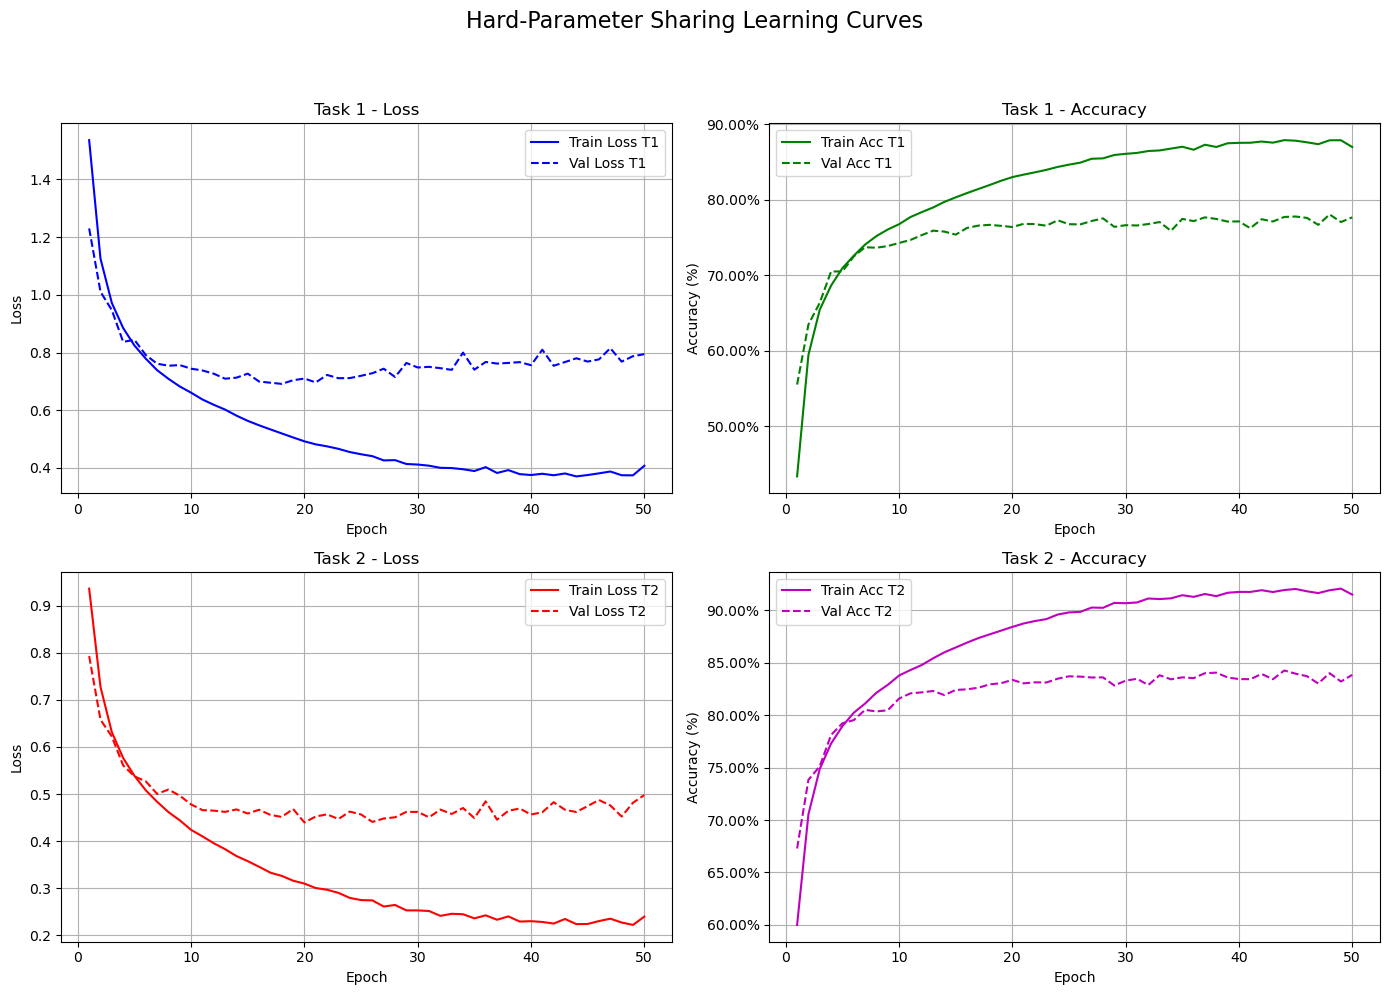

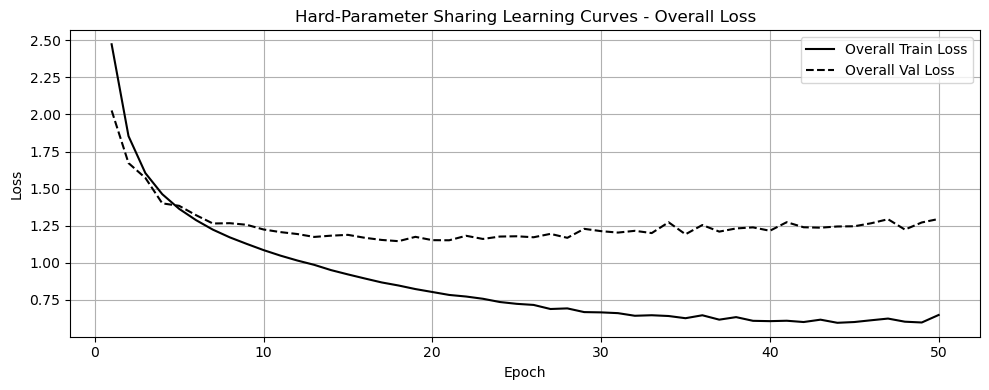

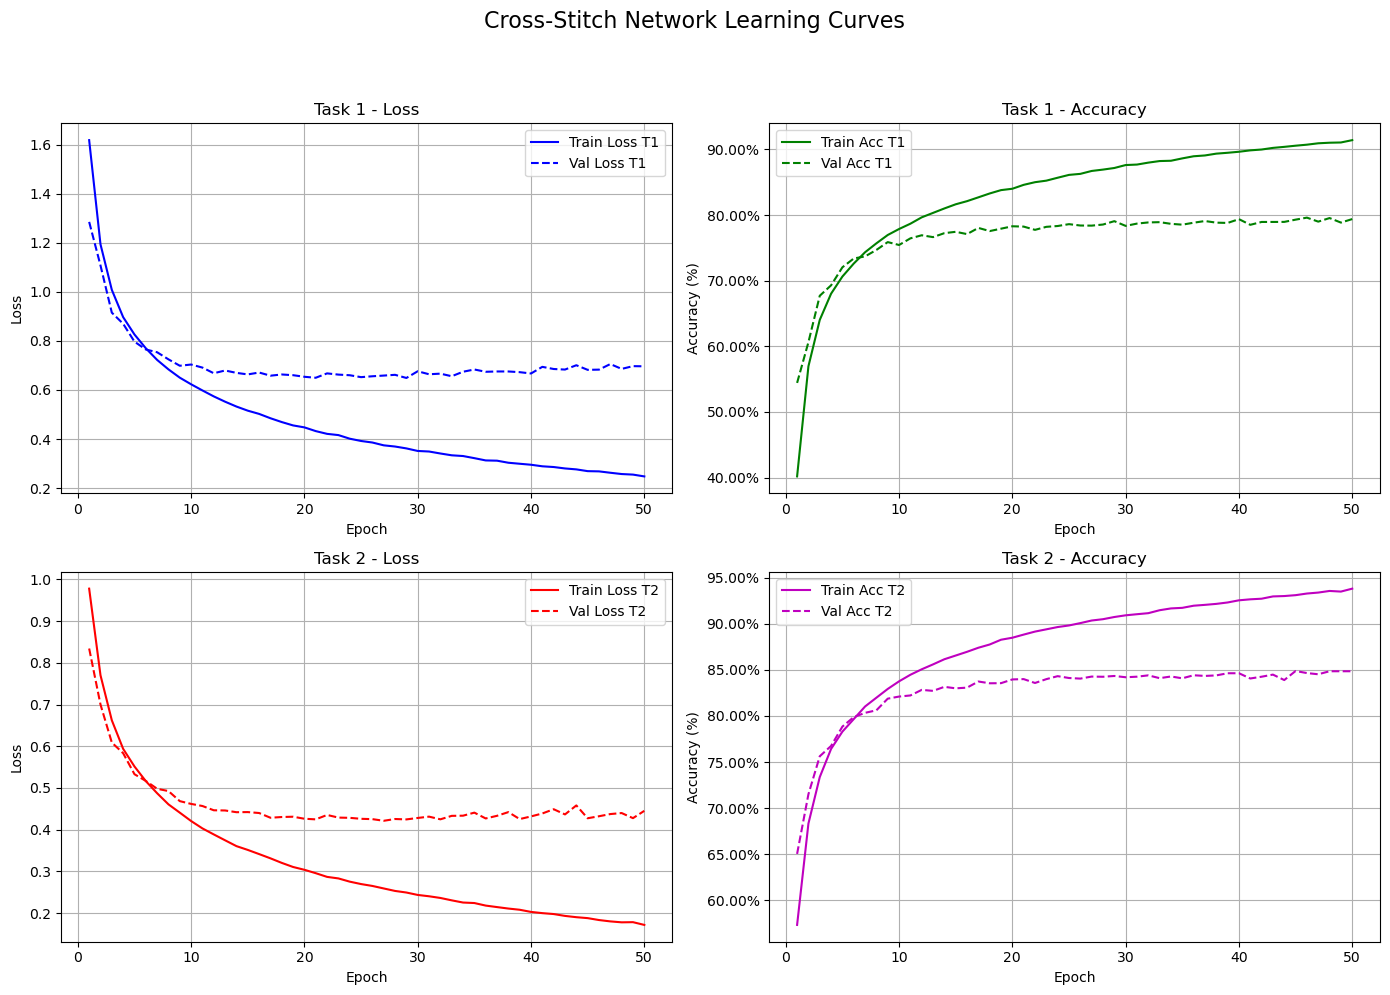

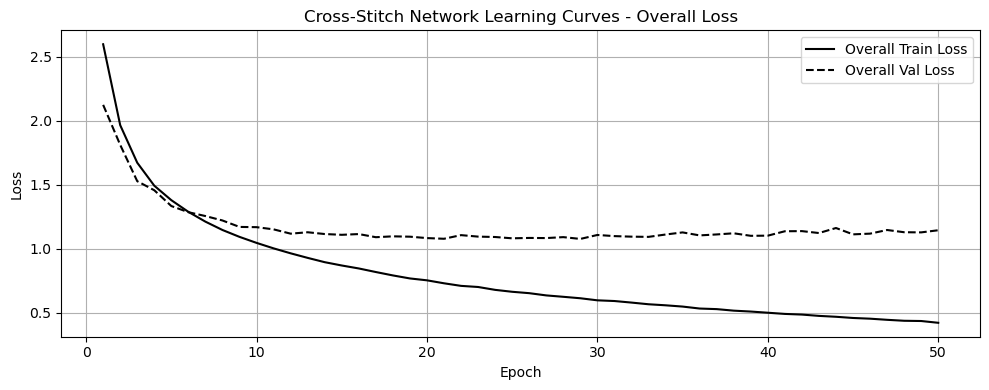

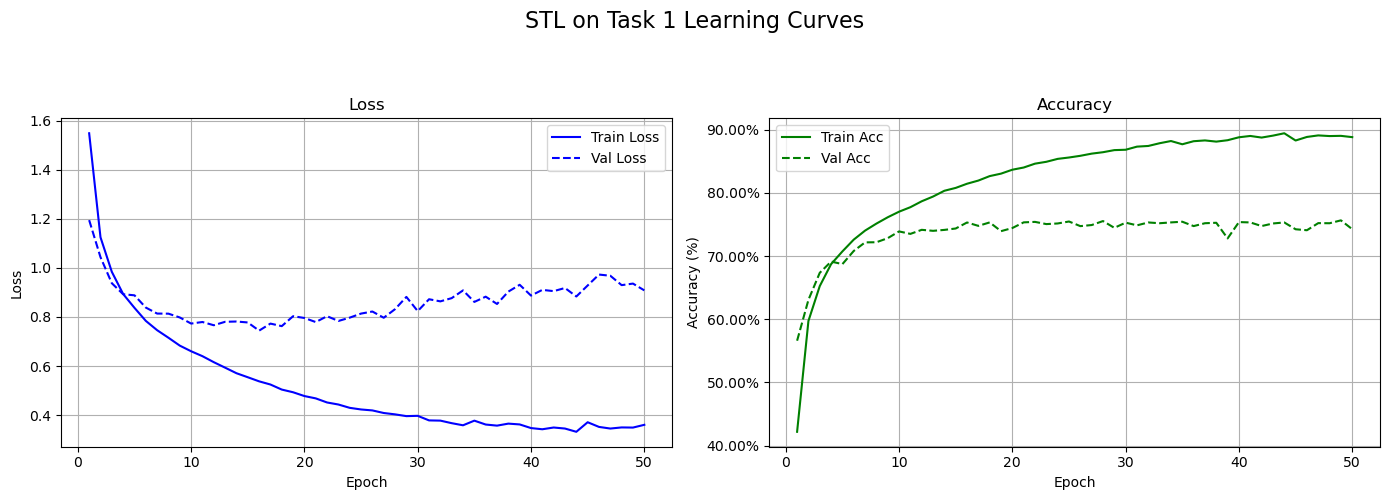

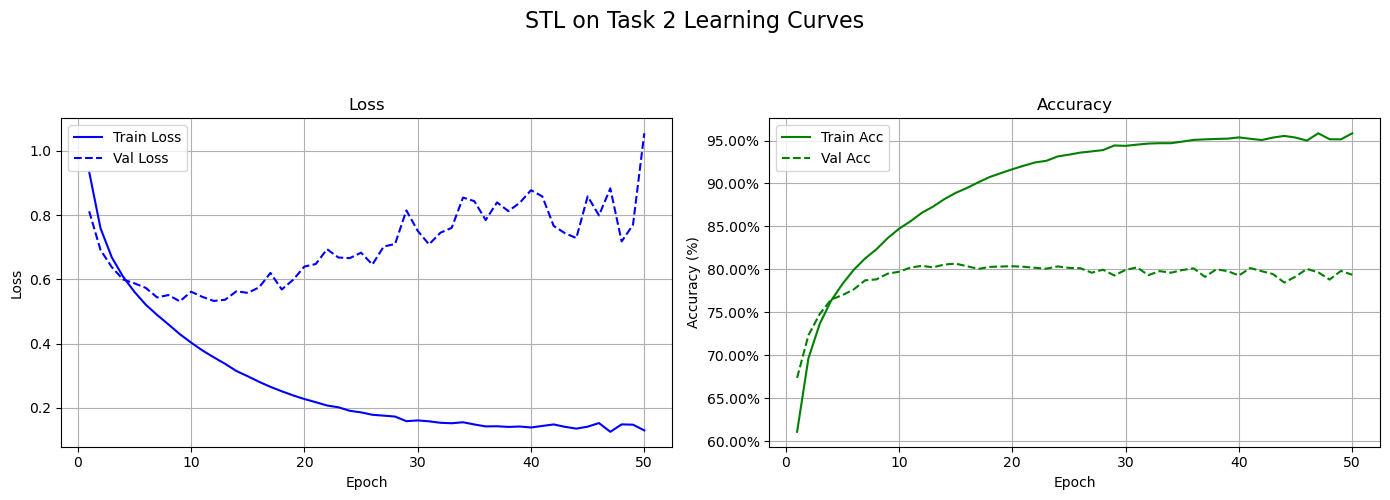

In [21]:
def plot_history(history, title, model_type):
    """Plots the training and validation history with accuracy in percentage (2 decimal places)."""
    epochs_range = range(1, NUM_EPOCHS + 1)

    formatter = mtick.FuncFormatter(lambda y, pos: f'{y:.2f}%')

    if model_type == 'mtl':
        plt.figure(figsize=(14, 10))
        plt.suptitle(title, fontsize=16, y=1.02)

        # Task 1 - Loss
        plt.subplot(2, 2, 1)
        plt.plot(epochs_range, history['train_loss_t1'], 'b-', label='Train Loss T1')
        plt.plot(epochs_range, history['val_loss_t1'], 'b--', label='Val Loss T1')
        plt.title('Task 1 - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Task 1 - Accuracy (%)
        plt.subplot(2, 2, 2)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc_t1']], 'g-', label='Train Acc T1')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc_t1']], 'g--', label='Val Acc T1')
        plt.title('Task 1 - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        # Task 2 - Loss
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, history['train_loss_t2'], 'r-', label='Train Loss T2')
        plt.plot(epochs_range, history['val_loss_t2'], 'r--', label='Val Loss T2')
        plt.title('Task 2 - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Task 2 - Accuracy (%)
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc_t2']], 'm-', label='Train Acc T2')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc_t2']], 'm--', label='Val Acc T2')
        plt.title('Task 2 - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()

        # Overall Loss
        plt.figure(figsize=(10, 4))
        plt.plot(epochs_range, history['train_loss'], 'k-', label='Overall Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'k--', label='Overall Val Loss')
        plt.title(f'{title} - Overall Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else: # STL
        plt.figure(figsize=(14, 5))
        plt.suptitle(title, fontsize=16, y=1.02)

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs_range, history['val_loss'], 'b--', label='Val Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy (%)
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, [acc * 100 for acc in history['train_acc']], 'g-', label='Train Acc')
        plt.plot(epochs_range, [acc * 100 for acc in history['val_acc']], 'g--', label='Val Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.gca().yaxis.set_major_formatter(formatter)
        plt.legend()
        plt.grid(True)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_history(history_hard_mtl, "Hard-Parameter Sharing Learning Curves", "mtl")
plot_history(history_cs, "Cross-Stitch Network Learning Curves", "mtl")
plot_history(history_stl_task1, "STL on Task 1 Learning Curves", "stl")
plot_history(history_stl_task2, "STL on Task 2 Learning Curves", "stl")

### 5.2. Interpreting Cross-Stitch Alpha Coefficients

Before plotting the alpha values, let's recall what they represent. The 2x2 alpha matrix $\mathbf{A} = \begin{pmatrix} \alpha_{11} & \alpha_{12} \\ \alpha_{21} & \alpha_{22} \end{pmatrix}$ determines how features are combined:
- **$\alpha_{S}$ (Diagonal: $\alpha_{11}, \alpha_{22}$)**: Represents *self-reliance*. How much a task uses its *own* features.
- **$\alpha_{D}$ (Off-Diagonal: $\alpha_{12}, \alpha_{21}$)**: Represents *information sharing*. How much a task uses features from the *other* task.

We started with $\alpha = 0.5$ for all values (neutral). By observing how these change, we can see if the network learned to:
* **Isolate tasks**: High $\alpha_S$, low $\alpha_D$.
* **Share features**: Significant $\alpha_D$.

This provides direct insight into the "soft" sharing mechanism.

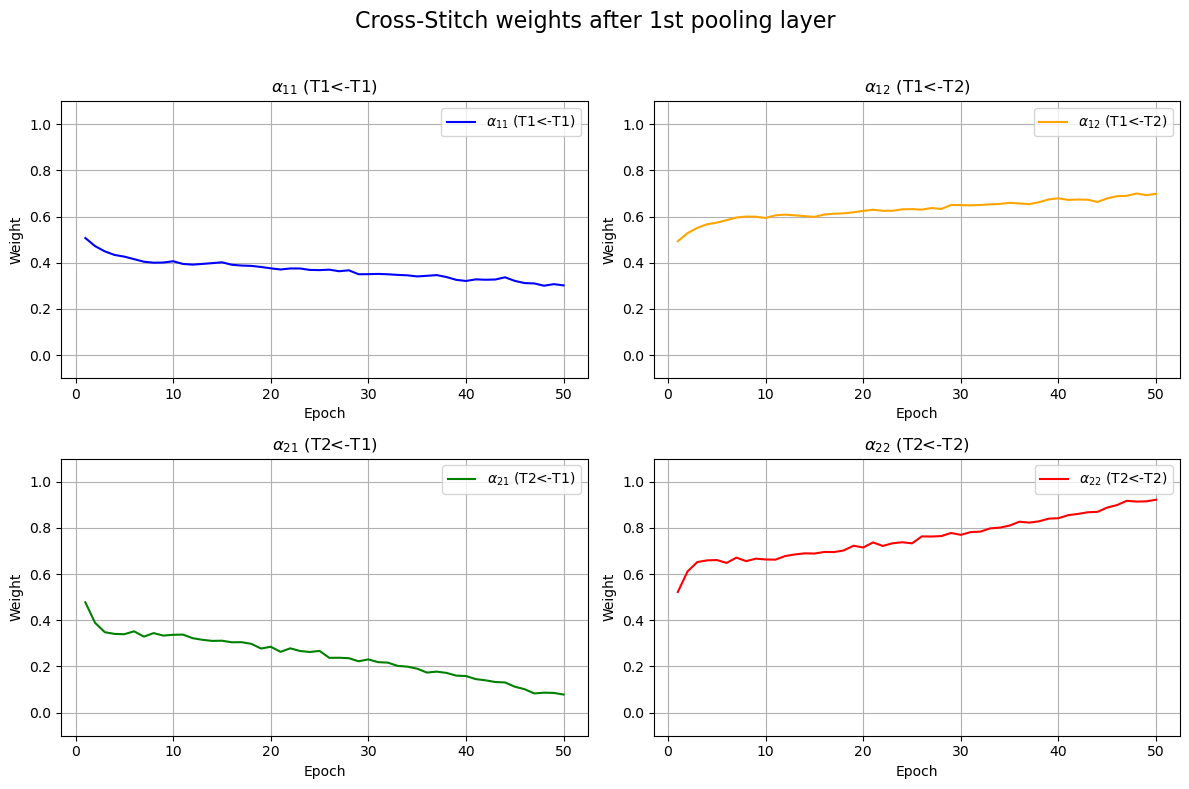

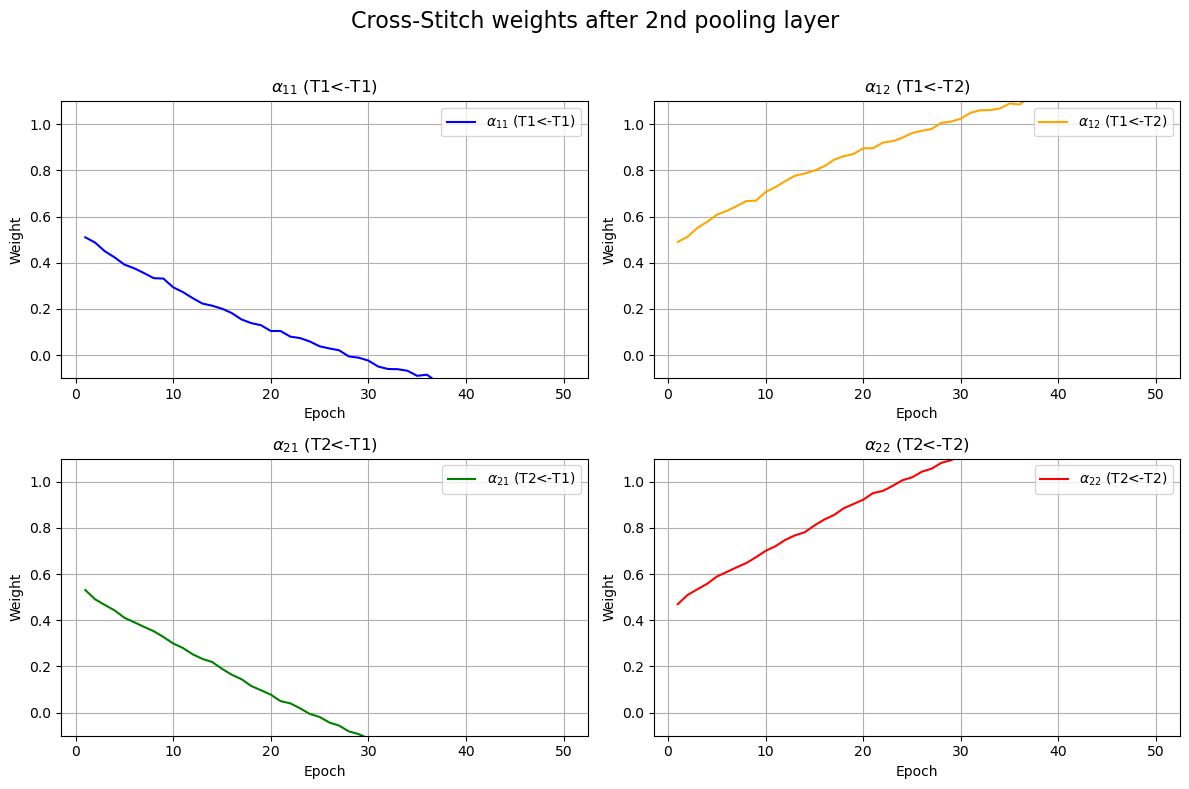

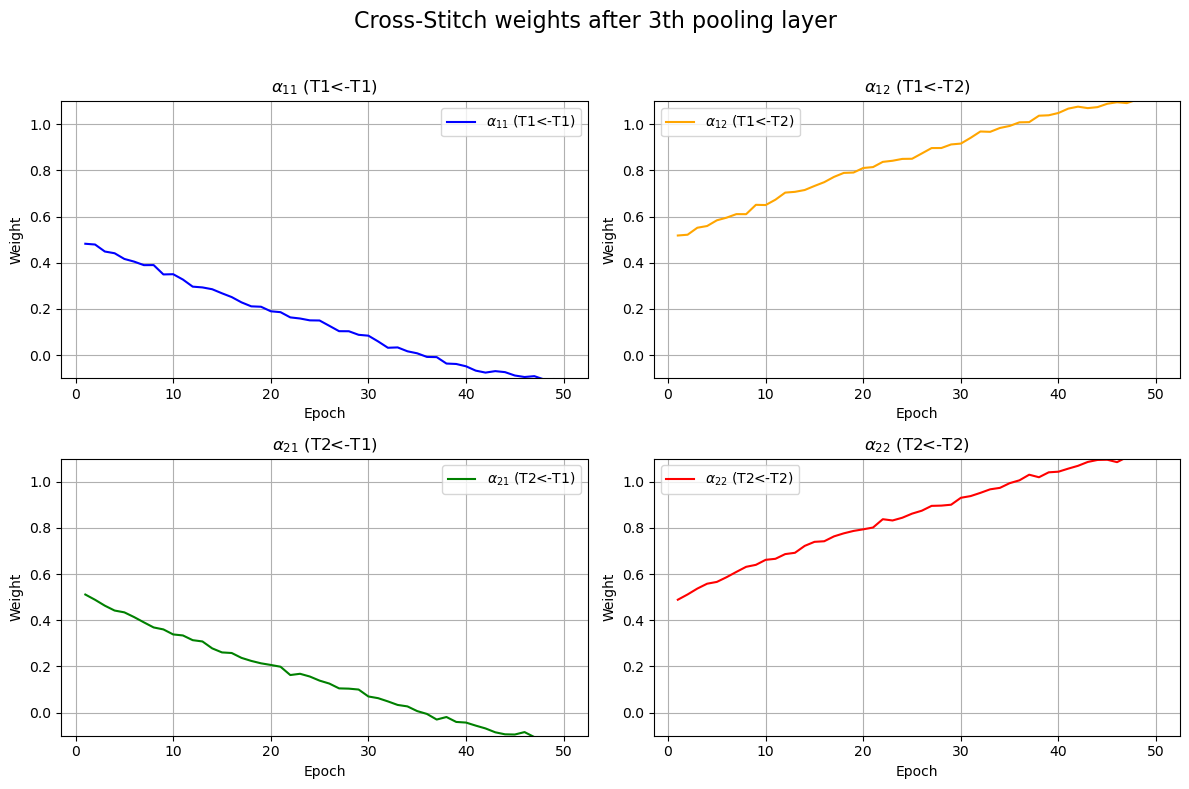

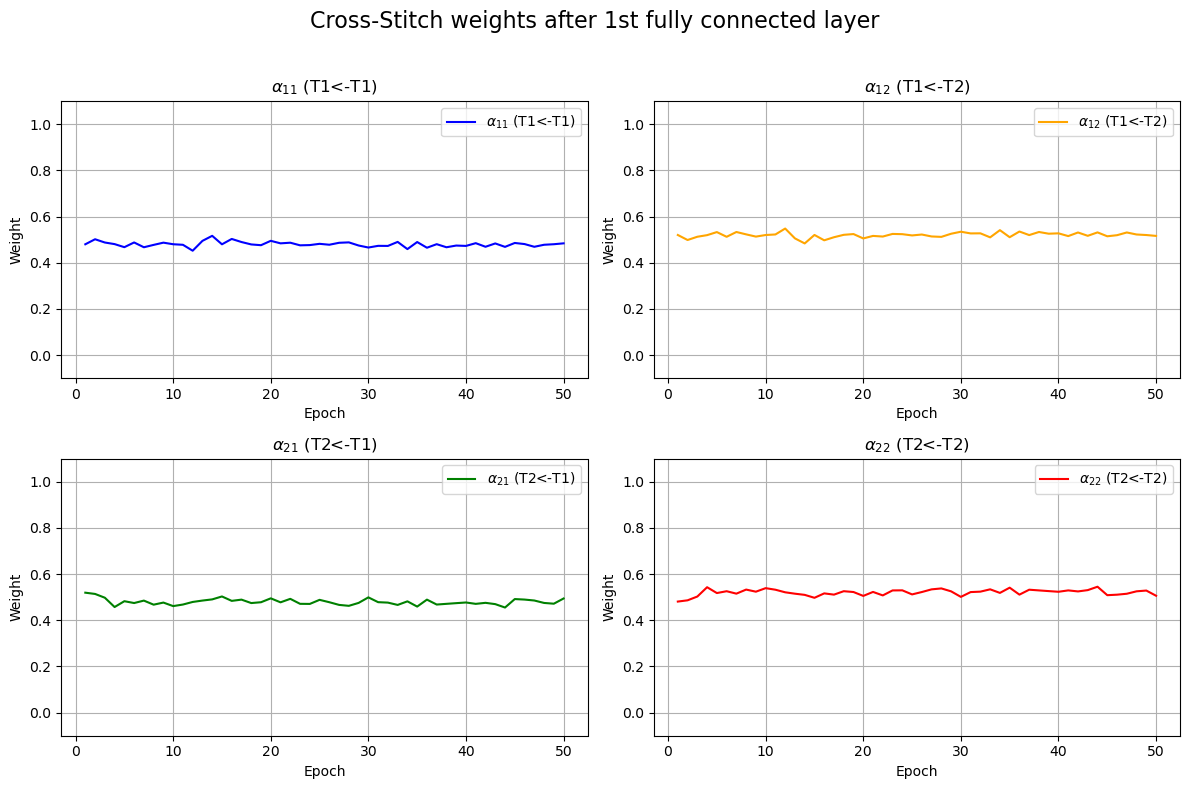

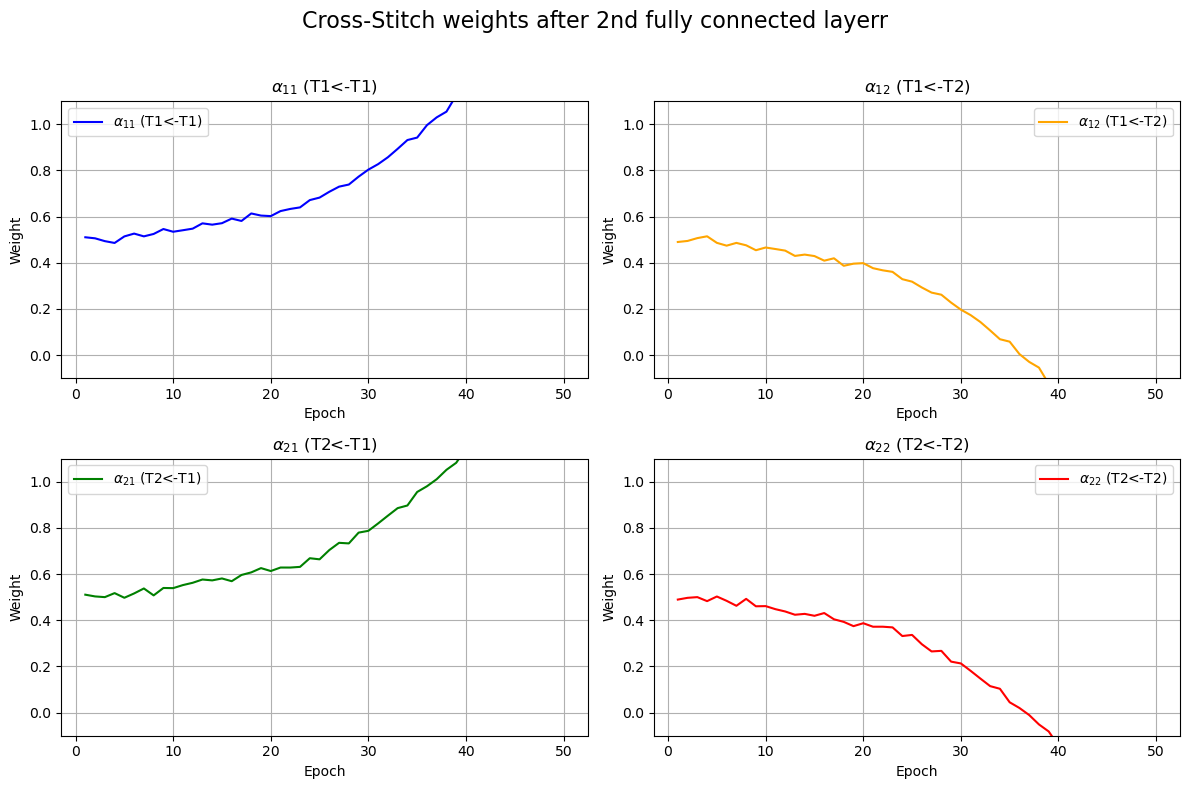

In [22]:
def plot_alpha_history(
    alpha_history_cs1,
    alpha_history_cs2,
    alpha_history_cs3,
    alpha_history_cs4,
    alpha_history_cs5,
    num_epochs):

    """Plots the evolution of alpha coefficients."""
    alphas_cs1_np = np.array(alpha_history_cs1)
    alphas_cs2_np = np.array(alpha_history_cs2)
    alphas_cs3_np = np.array(alpha_history_cs3)
    alphas_cs4_np = np.array(alpha_history_cs4)
    alphas_cs5_np = np.array(alpha_history_cs5)
    epochs_range = range(1, num_epochs + 1)

    # Plotting alpha values after pooling layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st pooling layer", fontsize=16)
    labels = [r'$\alpha_{11}$ (T1<-T1)', r'$\alpha_{12}$ (T1<-T2)', r'$\alpha_{21}$ (T2<-T1)', r'$\alpha_{22}$ (T2<-T2)']
    colors = ['blue', 'orange', 'green', 'red']
    indices = [(0, 0), (0, 1), (1, 0), (1, 1)]

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs1_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs2_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after pooling layer 3
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 3th pooling layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs3_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 1
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 1st fully connected layer", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs4_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plotting alpha values after fully connected layer 2
    plt.figure(figsize=(12, 8))
    plt.suptitle("Cross-Stitch weights after 2nd fully connected layerr", fontsize=16)

    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(epochs_range, alphas_cs5_np[:, indices[i][0], indices[i][1]], label=labels[i], color=colors[i])
        plt.xlabel("Epoch")
        plt.ylabel("Weight")
        plt.title(labels[i])
        plt.legend()
        plt.grid(True)
        plt.ylim(-0.1, 1.1)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_alpha_history(
    alpha_history_list_cs[0],
    alpha_history_list_cs[1],
    alpha_history_list_cs[2],
    alpha_history_list_cs[3],
    alpha_history_list_cs[4],
    NUM_EPOCHS)


In [23]:
# Count the number of parameters in each model
def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print Summary Table
print(f"| Approach                  | Trainable Parameters                  |")
print(f"|-------------------------- |---------------------------------------|")
print(f"| Hard-Parameter sharing    | {count_parameters(model_hard_mtl):,}  ")
print(f"| Cross-Stitch Network      | {count_parameters(model_cs):,}        ")
print(f"| STL on Task 1             | {count_parameters(model_stl_task1):,} ")
print(f"| STL on Task 2             | {count_parameters(model_stl_task2):,} ")

| Approach                  | Trainable Parameters                  |
|-------------------------- |---------------------------------------|
| Hard-Parameter sharing    | 12,755,790  
| Cross-Stitch Network      | 15,007,394        
| STL on Task 1             | 7,506,762 
| STL on Task 2             | 7,500,612 


### 5.3. Final Evaluation on Test Set
We load the *best* saved version of each model (based on validation performance during training) and evaluate it on the test set. This gives us our final comparison metrics.

In [24]:
print("\n--- Final Evaluation on Test Set ---\n")

print("\nHard-Parameter sharing:")
# --- Load and Evaluate Hard MTL ---
model_hard_mtl.load_state_dict(torch.load('best_alexnet_hard_mtl_model.pt', map_location=device))
_, test_loss_t1_h, test_acc_t1_h, test_loss_t2_h, test_acc_t2_h = generic_evaluate_epoch_mtl(
    model_hard_mtl, test_loader, criterion, device, None, phase="Test"
)

print("\nCross-Stitch Network:\n")
# --- Load and Evaluate Cross-Stitch ---
model_cs.load_state_dict(torch.load('best_alexnet_cs_model.pt', map_location=device))
_, test_loss_t1_c, test_acc_t1_c, test_loss_t2_c, test_acc_t2_c = generic_evaluate_epoch_mtl(
    model_cs, test_loader, criterion, device, None, phase="Test"
)

print("\nSTL on Task1:\n")
# --- Load and Evaluate STL Task 1 ---
model_stl_task1.load_state_dict(torch.load('best_alexnet_stl_task1_model.pt', map_location=device))
test_loss_t1_s, test_acc_t1_s = generic_evaluate_epoch_stl(
    model_stl_task1, test_loader, criterion, device, "task1", None, phase="Test"
)

print("\nSTL on Task2:\n")
# --- Load and Evaluate STL Task 2 ---
model_stl_task2.load_state_dict(torch.load('best_alexnet_stl_task2_model.pt', map_location=device))
test_loss_t2_s, test_acc_t2_s = generic_evaluate_epoch_stl(
    model_stl_task2, test_loader, criterion, device, "task2", None, phase="Test"
)


--- Final Evaluation on Test Set ---


Hard-Parameter sharing:


Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 1.1452
- T1: Loss: 0.6915 - Acc: 76.66%
- T2: Loss: 0.4514 - Acc: 82.94%

Cross-Stitch Network:



Test:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 1.0752
- T1: Loss: 0.6489 - Acc: 79.06%
- T2: Loss: 0.4246 - Acc: 84.33%

STL on Task1:



Test on task1:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 0.7441 - Acc: 75.30%

STL on Task2:



Test on task2:   0%|          | 0/313 [00:00<?, ?it/s]

Test
- Loss: 0.5318 - Acc: 79.51%


# Conclusions (Reflecting New Execution Results)

**Summary of Key Findings from the Latest Execution:**

Based on the analysis of the final evaluation results on the test set and the plots, the following observations were made:

* **Performance on Task 1 (Multi-class Object Classification):**
    * The STL model dedicated to T1 achieved an accuracy of **75.30%** with a final loss of **0.7441**.
    * The MTL models demonstrated superior performance:
        * **Hard-Parameter Sharing** achieved **76.66% accuracy** (Loss: 0.6915).
        * **Cross-Stitch Network** achieved **79.06% accuracy** (Loss: 0.6489), marking the best performance for T1.

* **Performance on Task 2 (Secondary Classification):**
    * The STL model dedicated to T2 obtained an accuracy of **79.51%** with a final loss of **0.5318**.
    * For this task, the MTL models also showed significant improvements:
        * **Hard-Parameter Sharing** achieved **82.94% accuracy** (Loss: 0.4514).
        * **Cross-Stitch Network** achieved **84.33% accuracy** (Loss: 0.4246), again representing the top performance for T2.

* **Overall MTL Performance:**
    * The Cross-Stitch Network also yielded the lowest combined test loss (1.0752) compared to Hard-Parameter Sharing (1.1452).

**Interpretation of Results and Implications:**

The data gathered from this new execution suggest that:

* **Scenario Favorable to MTL:** The MTL approach, particularly when employing the **Cross-Stitch Network** strategy, yielded tangible benefits. The performance increase observed on **both T1 and T2** indicates effective knowledge transfer between the tasks. The representations learned by the shared or interconnected components appear to have been enriched by the joint supervision, acting as a form of regularization and promoting more generalizable features, aligning with the theory of inductive transfer. Both MTL methods outperformed their STL counterparts on both tasks, with the Cross-Stitch Network showing a more pronounced advantage.

* **Cross-Stitch Alpha Value Trends:** An analysis of the alpha values in the Cross-Stitch matrix, which dictate the task-sharing proportions, reveals insightful dynamics:
    * In the **early convolutional layers** (post-pooling), Task 1 (multi-class object classification) tends to draw significantly from Task 2 (secondary classification). This suggests T1 benefits from the potentially more generalized features of T2, possibly enhanced by augmentations like rotations which can improve rotational-translational invariance. Conversely, Task 2 learns relatively less from Task 1 in these stages.
    * This pattern of information sharing **inverts in the later, fully connected layers** used for classification. This reversal indicates a dynamic adaptation in how tasks contribute to each other as features become more abstract and specialized for final decision-making.

**Final Remarks and Future Directions:**

This experimental iteration, with its specific outcomes, underscores the potential of Multi-Task Learning to enhance model performance by leveraging inter-task relationships, even with classic architectures. The Cross-Stitch Network, in particular, demonstrated a strong capability to effectively manage and benefit from shared information for the CIFAR-10 tasks defined, with its alpha parameters providing a glimpse into the adaptive learning process.

Based on these findings, future investigations could focus on:
* Exploring the hyperparameter space for the Cross-Stitch Network more thoroughly to potentially further optimize its performance.
* Investigating the application of these MTL techniques (especially Cross-Stitch) with more complex backbone architectures or on datasets with different characteristics or a larger number of tasks.
* A more in-depth analysis of the learned representations and alpha value dynamics within the Cross-Stitch Network across different layers and training stages to better understand how information is shared and transformed between tasks.
* Comparing with other adaptive MTL methods or exploring more sophisticated dynamic loss weighting schemes.

In conclusion, the results from this execution provide an updated and clearer perspective on the trade-offs and potential benefits of MTL for image classification with CIFAR-10, highlighting that adaptive MTL strategies like Cross-Stitch can offer significant improvements over both STL and simpler MTL approaches like hard parameter sharing.